# Exploring some basics from the MCS Zooms
## Written by Eric Rohr

In [19]:
### import modules
import illustris_python as il  # type: ignore
import matplotlib.pyplot as plt 
import numpy as np 
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.patheffects as pe 
import matplotlib.transforms as transforms  
from matplotlib.gridspec import GridSpec  
import matplotlib.gridspec as gridspec  
from matplotlib.patches import Patch  
import matplotlib.patches as patches  
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  
from mpl_toolkits.axes_grid1 import make_axes_locatable  
from scipy.ndimage import gaussian_filter  
from scipy import ndimage  
from scipy.interpolate import interp1d  
from scipy import interpolate  
#from tenet.util import sphMap  
import scipy.stats  
from scipy.stats import norm  
from sklearn.neighbors import KernelDensity  
from scipy.stats import ks_2samp, anderson_ksamp  
from scipy.optimize import curve_fit  
from astropy.cosmology import FlatLambdaCDM  
from astropy import units as u # tpye: ignore
from astropy import constants as const #type: ignore 
import os
import pathlib
import time
import h5py  
import rohr_utils as ru 
import random
import six  
import scida
from scida import load
import pint 

%matplotlib inline

plt.style.use('fullpage.mplstyle')

os.chdir('/u/reric/Scripts/')
! pwd



/vera/u/reric/Scripts


In [20]:
def createSimName(baseSim='L35n2160TNG', haloID=31619, targetRedshift=3, level=15, model='ST8', TNG50=False):
    """Create the simulation name from given parameters"""
    if TNG50:
        return 'TNG50-1'
    return '%s_h%d_z%d_L%d_%s'%(baseSim, haloID, targetRedshift, level, model)


def return_basePath(sim):
    """ return basePath for given simulation """
    valid_sims = ['L35n2160TNG_h31619_z3_L13_ST8',
                  'L35n2160TNG_h31619_z3_L14_ST8',
                  'L35n2160TNG_h31619_z3_L15_ST8',
                  'L35n2160TNG_h31619_z3_L15_TNG',
                  'L35n2160TNG_h31619_z3_L11_TNG',
                  'TNG50-1']
    if sim in valid_sims:
        if sim == 'TNG50-1':
            return './../sims.IllustrisTNG/%s/output/'%sim
        return './../sims.MCST/' + sim + '/output/'
    else:
        raise ValueError('sim %s not found'%sim)


def loadHaloCat(basePath, snapNum, haloID=0):
    """ load group information for given snapshot.
     Assumes the haloID of interest is in the 0th chunk. """
    f = h5py.File(basePath + '/groups_%03d/'%snapNum + 'fof_subhalo_tab_%03d.0.hdf5'%snapNum, 'r')
    Group = f['Group']
    r = {}
    for key in Group.keys():
        r[key] = Group[key][haloID]
    f.close()
    return r


def loadSubhaloCat(basePath, snapNum, subhaloID=0):
    """ load subhalo information for given snapshot.
     Assumes the subhaloID of interest is in the 0th chunk. """
    f = h5py.File(basePath + '/groups_%03d/'%snapNum + 'fof_subhalo_tab_%03d.0.hdf5'%snapNum, 'r')
    Subhalo = f['Subhalo']
    r = {}
    for key in Subhalo.keys():
        r[key] = Subhalo[key][subhaloID]
    f.close()
    return r
    
    
def return_GroupLenType(basePath, snapNum, haloID=0, partTypeNum=0):
    """ return GroupLenType for given snapshot. Assumes the 0th group is of interest, which is in the 0th chunk. """
    # open file
    f = h5py.File(basePath + '/groups_%03d/'%snapNum + 'fof_subhalo_tab_%03d.0.hdf5'%snapNum, 'r')
    Group = f['Group']
    r = Group['GroupLenType'][haloID][partTypeNum]
    f.close()
    return r


def return_SubhaloLenType(basePath, snapNum, subhaloID=0, partTypeNum=0):
    """ return SubhaloLenType for given snapshot. Assumes the 0th group is of interest, which is in the 0th chunk. """
    # open file
    f = h5py.File(basePath + '/groups_%03d/'%snapNum + 'fof_subhalo_tab_%03d.0.hdf5'%snapNum, 'r')
    Subhalo = f['Subhalo']
    r = Subhalo['SubhaloLenType'][subhaloID][partTypeNum]
    f.close()
    return r


code_mass = u.def_unit('code_mass', 1.0e10 * u.solMass)
code_length = u.def_unit('code_length', u.kpc)
code_velocity = u.def_unit('code_velocity', u.km / u.s)
def loadSubhalo(basePath, snapNum, subfindID=0, partTypeNum=0):
    """ load subhalo information for given snapshot """
    SubhaloLenType = return_SubhaloLenType(basePath, snapNum, subfindID, partTypeNum)
    snap = h5py.File(basePath + '/snapdir_%03d/'%snapNum + 'snap_%03d.0.hdf5'%snapNum, 'r')
    Header = dict(snap['Header'].attrs.items())
    NumPart_ThisFile = Header['NumPart_ThisFile']

    # are all the FoF particles in the first chunk?
    r = {}
    if SubhaloLenType <= NumPart_ThisFile[partTypeNum]:
        snapPartType = snap['PartType%d'%partTypeNum]
        for key in snapPartType.keys():
            dset = snapPartType[key]
            dset_attrs = dict(dset.attrs.items())
            try:
                r[key] = dset[:SubhaloLenType] * (Header['Time']**(dset_attrs['a_scaling']) * Header['HubbleParam']**(dset_attrs['h_scaling']) *
                                                  code_mass**(dset_attrs['mass_scaling']) * code_length**(dset_attrs['length_scaling']) * code_velocity**(dset_attrs['velocity_scaling']))
            except KeyError:
                r[key] = dset[:SubhaloLenType]
        r['count'] = SubhaloLenType
    else: 
        raise ValueError('SubhaloLenType > NumPart_ThisFile')

    snap.close()
    return r


def loadHeader(basePath, snapNum):
    """ load Header information for given snapshot """
    snap = h5py.File(basePath + '/snapdir_%03d/'%snapNum + 'snap_%03d.0.hdf5'%snapNum, 'r')
    Header = dict(snap['Header'].attrs.items())
    snap.close()
    return Header


def loadParameters(basePath, snapNum):
    """ load Parameters information for given snapshot """
    snap = h5py.File(basePath + '/snapdir_%03d/'%snapNum + 'snap_%03d.0.hdf5'%snapNum, 'r')
    Parameters = dict(snap['Parameters'].attrs.items())
    snap.close()
    return Parameters


def calcCosmicTime(Header):
    """Compute the Cosmic Time given the cosmological parameters in Header"""
    cosmo = FlatLambdaCDM(H0=Header['HubbleParam'] * 100.0, Om0=Header['Omega0'], Ob0=Header['OmegaBaryon'], Tcmb0=2.73)
    return cosmo.age(Header['Redshift']).value


def createSnapTimes(sim):
    """Create postprocessing file with snapshot times"""
    basePath = return_basePath(sim)
        
    # check if file already exists
    out_fname = os.path.join(pathlib.Path(basePath).parent, 'postprocessing', 'snaptimes.hdf5')
    if os.path.isfile(out_fname):
        print('File %s already exists'%out_fname)
        return

    # find all snapshot output files
    snap_fnames = []
    for name in os.listdir(basePath):
        if 'snapdir' in name:
            snap_fnames.append(name)
    snap_fnames.sort()

    # initialize result dictionary
    r = {}
    r['SnapNum'] = np.zeros(len(snap_fnames), dtype=int) - 1
    r['Redshift'] = np.zeros(len(snap_fnames), dtype=float) - 1.0
    r['Time'] = r['Redshift'].copy()
    r['CosmicTime'] = r['Redshift'].copy()

    # loop over snapshots and fill in result dictionary
    for i, snap_fname in enumerate(snap_fnames):
        snapNum = int(snap_fname[-3:])
        with h5py.File(os.path.join(basePath, snap_fname, 'snap_%03d.0.hdf5'%snapNum), 'r') as f:
            Header = dict(f['Header'].attrs.items())
            r['SnapNum'][i] = snapNum
            r['Redshift'][i] = Header['Redshift']
            r['Time'][i] = Header['Time']
            r['CosmicTime'][i] = calcCosmicTime(Header)
            f.close()

    # check that all entries are filled
    for key in r:
        assert r[key].all() != -1, 'Error: %s'%key

    # write hdf5 file    
    with h5py.File(out_fname, 'w') as f:
        for key in r:
            f.create_dataset(key, data=r[key])
        f.close()
    
    return 


def loadSnapTimes(sim):
    """Load postprocessing file with snapshot times"""

    basePath = return_basePath(sim)
    fname = os.path.join(pathlib.Path(basePath).parent, 'postprocessing', 'snaptimes.hdf5')
    if not os.path.isfile(fname):
        createSnapTimes(sim)
    with h5py.File(fname, 'r') as f:
        r = {}
        for key in f:
            r[key] = f[key][()]
        f.close()
    return r


def findSnapNum(sim, key='Redshift', val=5.0):
    """Find the snapshot number closest to the given key, value pair"""

    snapTimes = loadSnapTimes(sim)
    index = np.argmin(np.abs(snapTimes[key] - val))
    closest_val = snapTimes[key][index]
    if np.abs(closest_val - val) / val > 0.01:
        raise RuntimeWarning('No snapshot found with %s = %.3f. Closest value is %.3f.'%(key, val, closest_val))
    return snapTimes['SnapNum'][index]


standard_mass = u.Msun
standard_length = u.kpc
standard_velocity = u.km / u.s 
standard_time = u.yr
standard_massderivative = u.Msun / u.yr 
standard_volume = (standard_length)**3
standard_energy = u.erg
standard_density = standard_mass / standard_volume
standard_temperature = u.K
standard_metallicity = u.def_unit('Zsun', doc='Solar Metallicity', format=dict(latex=r'Z_{\odot}', latex_inline=r'Z_{\odot}'))
standard_pressure = u.erg / u.cm**3
#standard_pressure = (standard_mass / standard_length) / standard_time**2
def convertUnits(Sim):
    """ Convert all loaded properties to standard units """

    Header = Sim.Header
    for key in Sim.SubhaloGas:
        dset = Sim.SubhaloGas[key]
        # check if the quantity already has code units attached
        if isinstance(dset, u.quantity.Quantity):
            # yes, let's convert to standard units
            if dset.unit == code_mass**0 == code_length**0 == code_velocity**0:
                Sim.SubhaloGas[key] = dset.value * u.dimensionless_unscaled 
            elif dset.unit == code_mass:
                Sim.SubhaloGas[key] = dset.to(standard_mass)
            elif dset.unit == code_length:
                Sim.SubhaloGas[key] = dset.to(standard_length)
            elif dset.unit == code_velocity:
                Sim.SubhaloGas[key] = dset.to(standard_velocity)
            elif dset.unit == code_mass * code_velocity / code_length:
                Sim.SubhaloGas[key] = dset.to(standard_massderivative)
            elif dset.unit == code_mass / code_length**3:
                Sim.SubhaloGas[key] = dset.to(standard_density)
            elif dset.unit == (code_velocity)**2:
                Sim.SubhaloGas[key] = dset.to(standard_velocity**2)
            elif dset.unit == (code_mass * code_velocity**2 / code_length**3):
                Sim.SubhaloGas[key] = dset.to(standard_pressure)
            elif key == 'GFM_AGNRadiation':
                Sim.SubhaloGas[key] = (dset.value * u.erg / u.s / u.cm**2) / (4. * np.pi)
            else:
                raise ValueError('%s with unit %s has not had its units converted'%(key, dset.unit))

        # if no code units, then manually attach units 
        else:
            dimensionless_keys = ['AllowRefinement', 'HIIMassFraction', 'HIMassFraction', 
                                  'HeIIIMassFraction', 'HeIIMassFraction', 'HeIMassFraction',
                                  'Machnumber', 'StromgrenSourceID', 'count']
            if key in dimensionless_keys:
                Sim.SubhaloGas[key] *= u.dimensionless_unscaled
            else:
                Sim.SubhaloGas[key] *= u.def_unit('code_%s'%key)

        dset = Sim.SubhaloGas[key]
        # manual edits to certain datasets
        if key == 'EnergyDissipation':
            Sim.SubhaloGas[key] = (dset.value * Header['Time']**-1 * code_mass / code_length * code_velocity**3).to(standard_energy / standard_time)
        elif key == 'GrackleCoolTime':
            Sim.SubhaloGas[key] = (dset.value / Header['HubbleParam'] * standard_length / standard_velocity).to(standard_time)
        elif key == 'CoolingTime':
            Sim.SubhaloGas[key] = (dset.value * u.Gyr).to(standard_time)
        elif key in ['GrackleTemperature', 'Temperature']:
            Sim.SubhaloGas[key] = dset.value * standard_temperature
        elif key == 'HighResGasMass':
            Sim.SubhaloGas[key] = (dset.value / Header['HubbleParam'] * code_mass).to(standard_mass)
        elif key in ['Metallicity', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged']:
            Sim.SubhaloGas[key] = dset.value / 0.0127 * standard_metallicity
        elif key == 'RadiationEnergyDensity':
            Sim.SubhaloGas[key] = (dset.value * Header['HubbleParam']**2 * code_mass * code_velocity**2 / code_length**3).to(standard_energy / standard_volume)
        elif key == 'StromgrenRadius':
            Sim.SubhaloGas[key] = (dset.value * Header['Time'] / Header['HubbleParam'] * code_length).to(standard_length)
        elif key == 'MagneticField':
            Sim.SubhaloGas[key] = (dset.value * (code_mass / code_length)**(1/2) / (code_length / code_velocity)).to(standard_pressure**(1/2))
        elif key in ['MagneticFieldDivergence', 'MagneticFieldDivergenceAlternative']:
            Sim.SubhaloGas[key] = dset.value * u.def_unit('%s_units'%key)

        # final check that all units have been converted
        if 'code' in Sim.SubhaloGas[key].unit.to_string():
            raise UserWarning('%s not converted from units %s'%(key, Sim.SubhaloGas[key].unit.to_string()))

    return 
            

def computeCellSizes(Sim):
    """ add CellSize dataset to Sim.SubhaloGas """
    
    SubhaloGas = Sim.SubhaloGas
    if not Sim.TNG50:
        CellSizes = ((SubhaloGas['Masses'] / (4./3. * np.pi * SubhaloGas['Density']))**(1./3.)).to('kpc')
    else:
        CellSizes = (SubhaloGas['Masses'] * 1.0e10 / Sim.Header['HubbleParam'] /
                     (SubhaloGas['Density'] * 4./3. * np.pi * 1.0e10 / Sim.Header['HubbleParam'] / (Sim.Header['Time'] / Sim.Header['HubbleParam'])**3))**(1./3.)
    Sim.SubhaloGas['CellSizes'] = CellSizes

    return

def computeGasPressure(Sim):
    """ add Pressure dataset to Sim.SubhaloGas """
    
    gamma = 5. / 3. 

    SubhaloGas = Sim.SubhaloGas
    if not Sim.TNG50:
        Pressure = (gamma - 1.) * SubhaloGas['Density'] * SubhaloGas['InternalEnergy']
    else:
        Pressure = (gamma - 1.) * (SubhaloGas['Density'] * 1.0e10 / Sim.Header['HubbleParam'] / (Sim.Header['Time'] / Sim.Header['HubbleParam'])**3) * SubhaloGas['InternalEnergy']

    Sim.SubhaloGas['Pressure'] = Pressure

    return

    


In [21]:
class Sim: 
    """Create a class for the given simulation"""

    def __init__(self, baseSim='L35n2160TNG', targetHaloID=31619, targetRedshift=3, level=15, model='ST8', key='Redshift', val=5.0, subfindID=0, TNG50=False):
        """ initialize the class. Note that the TNG50 flag is only to be used for the original TNG50 simulation"""

        kwargs = locals().copy()
        for _key in kwargs:
            if _key != 'self':
                setattr(self, _key, kwargs[_key])

        self.sim = createSimName(self.baseSim, self.targetHaloID, self.targetRedshift, self.level, self.model, self.TNG50)
        self.basePath = return_basePath(self.sim)
        self.snapNum = findSnapNum(self.sim, self.key, self.val)
        self.Header = loadHeader(self.basePath, self.snapNum)
        self.Parameters = loadParameters(self.basePath, self.snapNum)
        self.snapTimes = loadSnapTimes(self.sim)
        index = self.snapTimes['SnapNum'] == self.snapNum
        self.Redshift = self.snapTimes['Redshift'][index][0]
        self.Time = self.snapTimes['Time'][index][0]
        self.CosmicTime = self.snapTimes['CosmicTime'][index][0]

        # load subhalo information   
        # if original TNG50 sim, use standard illustris python scripts 
        if TNG50:
            self.model = 'TNG'
            snapNum_target = findSnapNum(self.sim, val=targetRedshift)
            Halo_targetRedshift = il.groupcat.loadSingle(self.basePath, snapNum_target, haloID=31619)
            tree = ru.loadMainTreeBranch(self.sim, snapNum_target, subfindID=Halo_targetRedshift['GroupFirstSub'], fields=['SnapNum', 'SubfindID'])
            snapNum_interest = findSnapNum(self.sim, val=val)
            subfindID_interest = tree['SubfindID'][tree['SnapNum'] == snapNum_interest][0]
            self.snapNum = snapNum_interest
            self.Subhalo = il.groupcat.loadSingle(self.basePath, snapNum_interest, subhaloID=subfindID_interest)
            self.Halo = il.groupcat.loadSingle(self.basePath, snapNum_interest, haloID=self.Subhalo['SubhaloGrNr'])
            self.subfindID = subfindID_interest
            self.SubhaloGas = il.snapshot.loadSubhalo(self.basePath, snapNum_interest, subfindID_interest, partType=0)
            self.SubhaloGas = ru.calc_tcool_dict(self.SubhaloGas, self.basePath, self.snapNum)

        # otherwise, use custom scripts
        else:
            self.Subhalo = loadSubhaloCat(self.basePath, self.snapNum, subfindID)
            self.Halo = loadHaloCat(self.basePath, self.snapNum, self.Subhalo['SubhaloGrNr'])
            self.SubhaloGas = loadSubhalo(self.basePath, self.snapNum, subfindID, partTypeNum=0)
        
        # add postprocessed datasets for TNG sims
        if self.model=='TNG':
            self.SubhaloGas['Temperature'] = ru.calc_temp_NOSFR(self.SubhaloGas['InternalEnergy'], self.SubhaloGas['ElectronAbundance'])

        computeCellSizes(self)
        computeGasPressure(self)

        # convert units
        if not TNG50:
            convertUnits(self)

        # define short titles for plotting
        self.plotTitle = r'%s L%d'%(self.model, self.level)
        if TNG50:
            self.plotTitle = r'TNG50 (L11)'
        add_kwargs(self)


def add_kwargs(Sim, **kwargs):
    """ add kwargs to class"""
    max_level = 16
    min_level = 11
    if Sim.TNG50:
        kwargs['cmap'] = mpl.colormaps['Greys'].copy()
    elif Sim.model == 'TNG':
        kwargs['cmap'] = mpl.colormaps['YlGn'].copy()
    elif Sim.model == 'ST8':
        kwargs['cmap'] = mpl.colormaps['RdPu'].copy()

    if Sim.level == 15:
        kwargs['ls'] = '-'
        kwargs['lw'] = 2.5
        kwargs['hatch'] = '/'
    elif Sim.level == 14:
        kwargs['ls'] = '--'
        kwargs['lw'] = 2.0
        kwargs['hatch'] = '\\'
    elif Sim.level <= 13:
        kwargs['ls'] = ':'
        kwargs['lw'] = 1.5
        kwargs['hatch'] = 'o'

    level = Sim.level
    if level <= 13:
        level = 13
    
    kwargs['c'] = kwargs['color'] = kwargs['cmap']((level - min_level) / (max_level - min_level))

    Sim.kwargs = kwargs
    return

In [22]:
L35n2160TNG_h31619_z3_L15_ST8 = Sim(model='ST8')
L35n2160TNG_h31619_z3_L14_ST8 = Sim(model='ST8', level=14)
L35n2160TNG_h31619_z3_L13_ST8 = Sim(model='ST8', level=13)
L35n2160TNG_h31619_z3_L15_TNG = Sim(model='TNG')
L35n2160TNG_h31619_z3_L11_TNG = Sim(model='TNG', level=11)
#TNG50_h31619_z3 = Sim(TNG50=True)

Sims = [L35n2160TNG_h31619_z3_L15_ST8,
        L35n2160TNG_h31619_z3_L14_ST8,
        L35n2160TNG_h31619_z3_L13_ST8,
        L35n2160TNG_h31619_z3_L15_TNG,
        L35n2160TNG_h31619_z3_L11_TNG]
        #TNG50_h31619_z3]

In [23]:
savefig = False
out_direc = '../Figures/MCST'


In [24]:
# Metallicity, GrackleCoolTime, and GrackleTemperature have different keys for TNG sims
dset_swap = dict(Metallicity='GFM_Metallicity', GrackleCoolTime='CoolingTime', GrackleTemperature='Temperature',
                 GFM_Metallicity='Metallicity', CoolingTime='GrackleCoolTime', Temperature='GrackleTemperature')
mask_keys = ['HeatingUp', 'CoolingDown']

def plot_nTphasespace(Sim, weights='Masses', x_key='Density', y_key='GrackleTemperature', savefig=False, mask=None, norm=True):
    """Plot number density vs temperature phase space, with optional weights"""

    if mask and mask not in mask_keys:
        raise ValueError('mask %s is currently not supported'%mask)

    fig, ax = plt.subplots(figsize=(7,5))

    SubhaloGas = Sim.SubhaloGas

    x_min = -4.0
    x_max = 7.0
    y_min = 1.0
    y_max = 6.5
    nbins = 200
    x_bins = np.linspace(x_min, x_max, nbins)
    y_bins = np.linspace(y_min, y_max, nbins)
    bins = [y_bins, x_bins]

    _Density = SubhaloGas['Density'].to(const.m_p/u.cm**3)

    text = 'Subhalo Gas'
    if not mask:
        _mask = np.ones_like(_Density.value, dtype=bool)
    else:
        if mask == mask_keys[0] or mask == mask_keys[1]:
            mask_key = 'GrackleCoolTime'
            if mask_key not in SubhaloGas:
                if mask_key in dset_swap:
                    mask_key = dset_swap[mask_key]
            _dset = SubhaloGas[mask_key]
            if mask == mask_keys[0]:
                _mask = _dset.value >= 0
                text += '\nHeating Up'
            else:
                _mask = _dset.value < 0
                text += '\nCooling Down'
    ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes)

    Density = _Density[_mask].value
    y = SubhaloGas[y_key][_mask].value
    Masses = SubhaloGas['Masses'][_mask].value

    stat_mass = scipy.stats.binned_statistic_2d(np.log10(y), np.log10(Density), Masses, statistic='sum', bins=bins)[0]

    if weights == 'Masses':
        if norm:
            stat = stat_mass / Masses.sum()
            cbar_label = r'Gas Mass Fraction'
            cbar_norm = mpl.colors.LogNorm(vmin=1.1e-7, vmax=9.9e-3)
        else:
            stat = stat_mass
            cbar_label = r'Gas Mass [%s]'%SubhaloGas['Masses'].unit.to_string('latex_inline')
            cbar_norm = mpl.colors.LogNorm(vmin=2e1, vmax=3.0e6)
        cmap = cm.viridis.copy()
        stat[(stat > 0) & (stat < cbar_norm.vmin)] = cbar_norm.vmin

    else:
        if weights not in SubhaloGas:
            if weights in dset_swap:
                weights = dset_swap[mask_key]
            else:
                raise ValueError('Error: %s not in SubhaloGas'%weights)
        _weights = SubhaloGas[weights][_mask]
        if mask == 'CoolingDown':
            _weights *= -1

        stat_weight = scipy.stats.binned_statistic_2d(np.log10(y), np.log10(Density), _weights.value * Masses, statistic='sum', bins=bins)[0]
        stat_mask = (stat_mass > 0) & (stat_weight > 0)
        stat = np.zeros_like(stat_mass)
        stat[stat_mask] = stat_weight[stat_mask] / stat_mass[stat_mask]
        cbar_label = r'%s [%s]'%(weights.replace('_', '\_'), _weights.unit.to_string('latex_inline'))
        cmap = cm.magma.copy()    
        if weights in ['Metallicity', 'GFM_Metallicity']:
            cbar_norm = mpl.colors.LogNorm(vmin=3.0e-5, vmax=3.0)
            stat[stat_mask & (stat < cbar_norm.vmin)] = cbar_norm.vmin
        elif weights in ['CoolingTime', 'GrackleCoolTime']:
            if not mask:
                raise ValueError('Key %s requires a mask'%weights)
            cbar_norm = mpl.colors.LogNorm(3.0e1, 3.0e8)
        else:
            cbar_norm = mpl.colors.LogNorm()

    if np.any(np.isnan(stat)):
        raise ValueError('Error: some values are NaN')

    cmap.set_under('white', 1.)
    cmap.set_bad('white', 1.)

    extent = [x_min,x_max, y_min, y_max]
    origin = 'lower'
    kwargs = dict(cmap=cmap, extent=extent, origin=origin, norm=cbar_norm)

    h = ax.imshow(stat, **kwargs)

    ax.set_ylabel(r'Gas Temperature $[\log_{10} {\rm K}]$')
    ax.set_xlabel(r'Gas Density $[\log_{10} {\rm m_H \, cm^{-3}}]$')

    cax = inset_axes(ax, width="40%", height="5%", loc='upper right', bbox_to_anchor=(0.05, 0.05, 0.95, 0.95), bbox_transform=ax.transAxes)
    cbar = fig.colorbar(h, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label)

    text = r'h%d $z=%.1f$'%(Sim.targetHaloID, Sim.Redshift) + '\n%s'%Sim.plotTitle
    ax.text(0.05, 0.05, text, transform=ax.transAxes, ha='left', va='bottom', ma='left')

    if savefig:
        out_fname = 'nTphasespace_%s_z%.1f_%s.pdf'%(Sim.sim, Sim.Redshift, weights)
        if norm and weights == 'Masses':
            out_fname = 'nTphasespace_%s_z%.1f_%s_norm.pdf'%(Sim.sim, Sim.Redshift, weights)
        if mask:
            out_fname = 'nTphasespace_%s_z%.1f_%s_%s.pdf'%(Sim.sim, Sim.Redshift, weights, mask)

        fig.savefig(os.path.join(out_direc, out_fname), bbox_inches='tight')

    return fig, ax

    

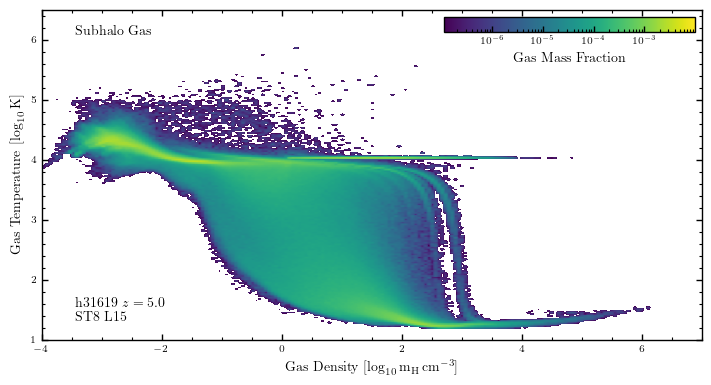

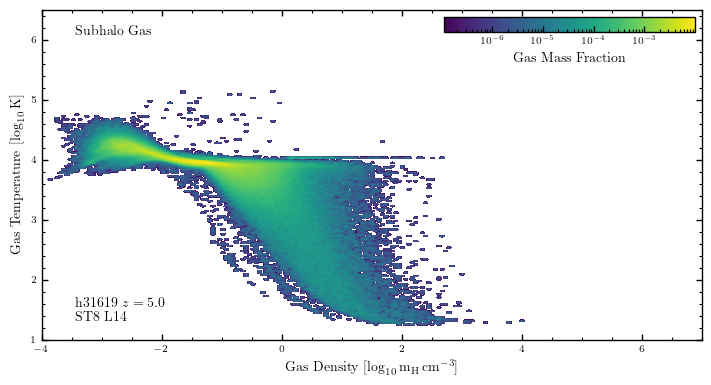

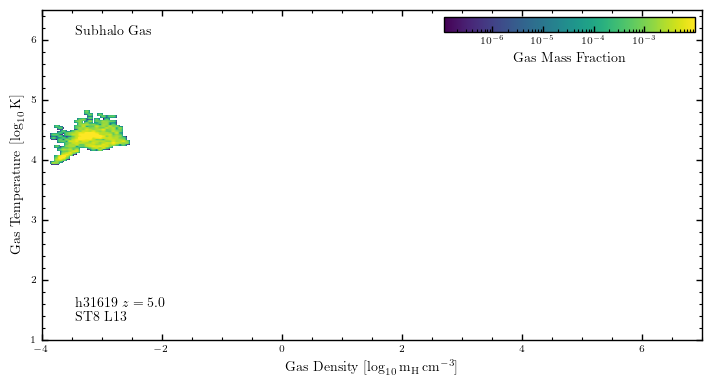

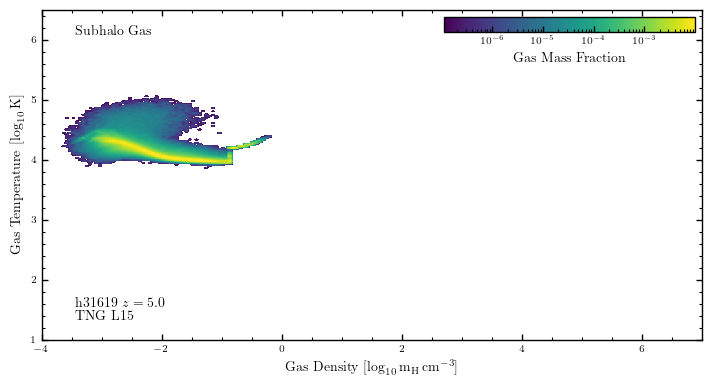

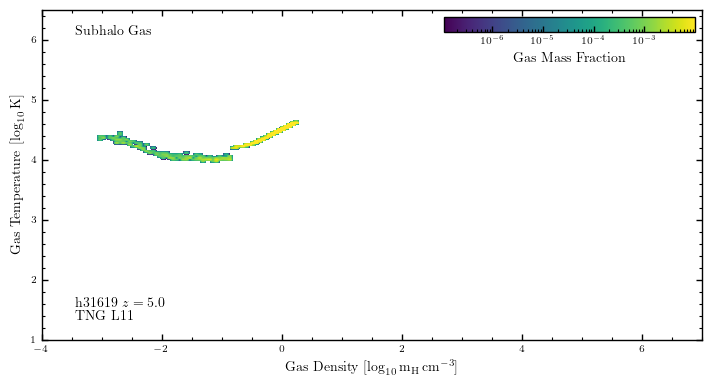

In [25]:
for weights in ['Masses']:
    for _Sim in Sims:
        y_key='GrackleTemperature'
        if _Sim.model == 'TNG':
            y_key='Temperature'
        _, _ = plot_nTphasespace(_Sim, y_key=y_key, savefig=savefig, weights=weights)

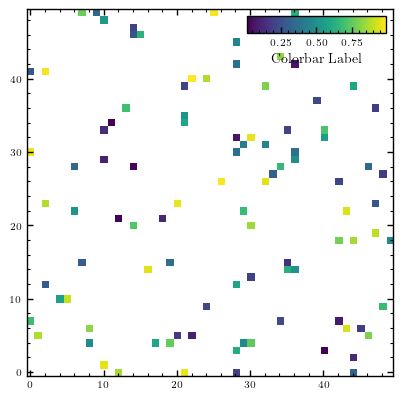

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  
import matplotlib.pyplot as plt
import numpy as np

seed = np.random.seed(0)
x = np.random.random(100)
y = np.random.random(100)
w = np.random.random(100)

fig, ax = plt.subplots()
stat = scipy.stats.binned_statistic_2d(x, y, w, bins=50, statistic='median')

h = ax.imshow(stat[0], origin='lower')

cax = inset_axes(ax, width="40%", height="5%", loc='upper right', bbox_to_anchor=(0.05, 0.05, 0.95, 0.95), bbox_transform=ax.transAxes)
cbar = fig.colorbar(h, cax=cax, orientation='horizontal')
cbar.set_label('Colorbar Label')

out_fname = 'test_2dhist.pdf'
#fig.savefig(out_fname, bbox_inches='tight')

In [ ]:
for _Sim in Sims:
    y_key='GrackleTemperature'
    weights='Metallicity'
    if _Sim.model == 'TNG':
        y_key='Temperature'
        weights='GFM_Metallicity'
    _, _ = plot_nTphasespace(_Sim, y_key=y_key, weights=weights, savefig=savefig)

In [ ]:
_, _ = plot_nTphasespace(Sims[0], weights='Masses', mask=None, norm=False, savefig=savefig)
_, _ = plot_nTphasespace(Sims[0], weights='Masses', mask='HeatingUp', norm=False, savefig=savefig)
_, _ = plot_nTphasespace(Sims[0], weights='Masses', mask='CoolingDown', norm=False, savefig=savefig)

fig, ax = plot_nTphasespace(Sims[0], weights='GrackleCoolTime', mask='HeatingUp', savefig=savefig)
fig, ax = plot_nTphasespace(Sims[0], weights='GrackleCoolTime', mask='CoolingDown', savefig=savefig)

In [10]:


def plot_HistogramComparison(Sims, dset_key='Masses', savefig=False, dset_log=True, nbins=50, xlabel=None, mass_weighted=True, addSFingGas=False):
    """Plot the 1D distribution of a given dataset across Sims"""

    # check if Sims is a singular instance of the class Sim
    if isinstance(Sims, Sim):
        Sims = [Sims]

    # start figure
    fig, ax = plt.subplots()
    ax.set_ylim(5.0e1, 2.0e8)
    ax.set_yscale('log')
    if mass_weighted:
        ylabel = r'Gas Mass per %s bin [%s]'%(dset_key.replace('_', '\_'), Sims[0].SubhaloGas['Masses'].unit.to_string('latex_inline'))
    else:
        ylabel = r'Number of Gas Cells per %s bin'%(dset_key)
    ax.set_ylabel(ylabel)
    if xlabel:
        ax.set_xlabel(xlabel)
    else:
        ax.set_xlabel(r'%s [$\log_{10}$ %s]'%(dset_key.replace('_', '\_'), Sims[0].SubhaloGas[dset_key].unit.to_string('latex_inline')))

    for _Sim_i, _Sim in enumerate(Sims):
        # currently only works for zoom simulations
        if _Sim.TNG50:
            raise ValueError('Currently not supported for TNG50')
    
        if dset_key not in _Sim.SubhaloGas:
            if dset_key in dset_swap:
                dset_key = dset_swap[dset_key]
            else:
                raise KeyError('dset_key %s not in _Sim.SubhaloGas or dset_swap'%dset_key)

        # find the min and max values across all sims to set the bins
        _dset = _Sim.SubhaloGas[dset_key]
        if dset_log: 
            dset = np.log10(_dset.value)
        else:
            dset = _dset.value

        if _Sim_i == 0:
            bin_min = dset.min()
            bin_max = dset.max()
        else:
            if dset.min() < bin_min:
                bin_min = dset.min()
            if dset.max() > bin_max:
                bin_max = dset.max()
        
    # add a small buffer on either side, which should work well if dset_log
    bin_min -= 0.5 
    bin_max += 0.5

    bins = np.linspace(bin_min, bin_max, nbins)
    bin_width = bins[1] - bins[0]

    for _Sim_i, _Sim in enumerate(Sims):
        _SubhaloGas = _Sim.SubhaloGas   
        if dset_key not in _Sim.SubhaloGas:
            if dset_key in dset_swap:
                dset_key = dset_swap[dset_key]
        _dset = _SubhaloGas[dset_key]

        if dset_log: 
            dset = np.log10(_dset.value)
        else:
            dset = _dset.value

        # make extra histograms for only SFing Gas?
        masks = [np.ones_like(dset, dtype=bool)]
        if addSFingGas:
            masks.append(_SubhaloGas['StarFormationRate'].value > 0)
            if _Sim_i == 0:
                ax.hist(np.zeros(0), bins=bins, histtype='stepfilled', color='tab:gray', label='SFing Gas', edgecolor='k')

        if mass_weighted:
            weights = _SubhaloGas['Masses'].value
        else:
            weights = np.ones_like(dset)
        
        for mask_i, mask in enumerate(masks):
            _kwargs = _Sim.kwargs.copy()
            # offset bins slightly for visual clarity
            _bins = bins + bin_width * 0.1 * _Sim_i
            kwargs = dict(weights=weights[mask], bins=_bins, histtype='step', label=_Sim.plotTitle,
                        color=_kwargs['c'], lw=_kwargs['lw'], ls=_kwargs['ls'])
            if mask_i == 1:
                kwargs.update(dict(alpha=0.25, histtype='stepfilled', hatch=_kwargs['hatch'], label=None, edgecolor='k'))
            ax.hist(dset[mask], **kwargs)

        # add vertical line at minimum hydro softening
        if dset_key == 'CellSizes':
            min_softening = np.log10(_Sim.Parameters['MinimumComovingHydroSoftening'] * _Sim.Header['Time'] / _Sim.Header['HubbleParam'])
            if _Sim.model == 'TNG' and _Sim.level == 15:
                min_softening += 0.05
            ax.vlines(min_softening, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors=_kwargs['c'], lw=1.5, zorder=1, alpha=1.0)

    ax.legend(title='h%s $z=%.1f$'%(_Sim.targetHaloID, _Sim.Redshift), loc='upper left')

    text = 'All Subhalo Gas'
    ax.text(0.975, 0.975, text, transform=ax.transAxes, ha='right', va='top', ma='right')

    if savefig:
        out_fname = 'HistogramComparison_%s_h%d_z%d_z%.1f_%s.pdf'%(_Sim.baseSim, _Sim.targetHaloID, _Sim.targetRedshift, _Sim.Redshift, dset_key)
        fig.savefig(os.path.join(out_direc, out_fname), bbox_inches='tight')

    return fig, ax
    

In [ ]:
dset_keys = ['Masses', 'Metallicity', 'GrackleTemperature', 'Density', 'Pressure', 'CellSizes']
for dset_key in dset_keys:
    addSFingGas = True
    fig, ax = plot_HistogramComparison(Sims, dset_key=dset_key, savefig=savefig, addSFingGas=addSFingGas)

In [12]:
dset = Sims[0].SubhaloGas['GrackleCoolTime']
dset_key = 'GrackleCoolTime'
weights_key = 'Masses'

def plot_CoolTimeHistogram(Sims, dset_key='GrackleCoolTime', weights_key='Masses', addSFingGas=False, savefig=False):
    """Plot the 1D histogram of the cooling time, split into positive and negative cooling times """

    if isinstance(Sims, Sim):
        Sims = [Sims]

    bin_min = -0.5
    bin_max = 15.0
    nbins = 50
    bins = np.linspace(bin_min, bin_max, nbins)
    bin_width = bins[1] - bins[0]

    fig, ax = plt.subplots()

    counter = 0
    handles_hists = []
    handles_Sims = []
    for _Sim_i, _Sim in enumerate(Sims):
        _SubhaloGas = _Sim.SubhaloGas   
        if dset_key not in _SubhaloGas:
            if dset_key in dset_swap:
                dset_key = dset_swap[dset_key]
        _dset = _SubhaloGas[dset_key]

        # make extra histograms for only SFing Gas?
        masks = [np.ones_like(_dset.value, dtype=bool)]
        if addSFingGas:
            masks.append(_SubhaloGas['StarFormationRate'].value > 0)
            if _Sim_i == 0:
                handles_hists.append(ax.hist(np.zeros(0), bins=bins, histtype='stepfilled', color='tab:gray', label='SFing Gas', edgecolor='k')[2][0])

        for mask_i, mask in enumerate(masks):
            cooling_mask = _dset[mask].value < 0
            _weights = _SubhaloGas[weights_key][mask]
            dset_neg = np.log10(-1.0 * _dset[mask][cooling_mask].value)
            dset_pos = np.log10(_dset[mask][~cooling_mask].value)

            _kwargs = _Sim.kwargs.copy()
            kwargs = dict(histtype='step', lw=_kwargs['lw'], ls=_kwargs['ls'])

            if _Sim_i == 0:
                label_pos = 'Heating Up'
                label_neg = 'Cooling Down'
            else:
                label_pos = label_neg = None

            if mask_i == 1:
                kwargs.update(dict(alpha=0.25, histtype='stepfilled', hatch=_kwargs['hatch'], edgecolor='k'))
                label_pos = label_neg = None
            else:
                handles_Sims.append(ax.hist([], **kwargs, color='tab:gray', label=_Sim.plotTitle)[2][0])

            # offset bins slightly for visual clarity
            handles_hists.append(ax.hist(dset_pos, bins=bins+(0.1*bin_width)*counter, weights=_weights[~cooling_mask].value, color='tab:red', label=label_pos, **kwargs)[2][0])
            counter += 1
            handles_hists.append(ax.hist(dset_neg, bins=bins+(0.1*bin_width)*counter, weights=_weights[cooling_mask].value, color='tab:blue', label=label_neg, **kwargs)[2][0])
            counter += 1

    # only show legend entries for hists with a label 
    hanldes_hists_plot = []
    for handle in handles_hists:
        if str(handle.get_label()) != 'None':
            hanldes_hists_plot.append(handle)
    legend = ax.legend(handles=hanldes_hists_plot, title='All Subhalo Gas', loc='upper right')
    ax.add_artist(legend)

    ax.set_yscale('log')
    ax.set_ylabel(r'Gas Mass per %s bin [%s]'%(dset_key, _weights.unit.to_string('latex_inline')))
    ax.set_xlabel(r'%s [$\log_{10}$ %s]'%(dset_key, _dset.unit.to_string('latex_inline')))
    ax.set_ylim(5.0e1, 5.0e7)

    text = r'h%d $z=%.1f$'%(_Sim.targetHaloID, _Sim.Redshift)
    legend_Sims = ax.legend(handles=handles_Sims, title=text, loc='upper left')

    if savefig:
        if len(Sims) == 1:
            out_fname = 'CoolingTimeHistogram_%s_z%.1f.pdf'%(_Sim.sim, _Sim.Redshift)
        else:
            out_fname = 'CoolingTimeHistogramComparison_%s_h%d_z%s_z%.1f.pdf'%(_Sim.baseSim, _Sim.targetHaloID, _Sim.targetRedshift, _Sim.Redshift)
        fig.savefig(os.path.join(out_direc, out_fname), bbox_inches='tight')

    return fig, ax


In [ ]:
_Sims = []
for _Sim in Sims:
    if _Sim.model == 'ST8':
        _Sims.append(_Sim)
        fig, ax = plot_CoolTimeHistogram(_Sim, addSFingGas=True, savefig=savefig)

fig, ax = plot_CoolTimeHistogram(_Sims, addSFingGas=False, savefig=savefig)



In [ ]:
Density = r['Density'][mask] * (1.0e10 / HubbleParam) / (Time / HubbleParam)**3
MsunKpc3_to_mHcm3 = 4.043 * 1.0e-8
GrackleTemperature = r['GrackleTemperature'][mask]
GrackleCoolTime = r['GrackleCoolTime'][mask] / HubbleParam * 977.813106 # Myr

In [ ]:
GrackleTemperatureMap = scipy.stats.binned_statistic_2d(Coordinates[:, 0], Coordinates[:, 1], GrackleTemperature, statistic='median', bins=250)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
h = ax.imshow(GrackleTemperatureMap.statistic.T, extent=[GrackleTemperatureMap.x_edge[0], GrackleTemperatureMap.x_edge[-1], GrackleTemperatureMap.y_edge[0], GrackleTemperatureMap.y_edge[-1]], origin='lower', cmap='turbo', norm=mpl.colors.LogNorm(vmin=1.0e1, vmax=3.0e4))

cbar = fig.colorbar(h, ax=ax)
cbar.set_label('Grackle Temperature [K]', fontsize=18)
cbar.ax.tick_params(labelsize=14)  # Increase the label size to 14

In [ ]:
GrackleCoolTimeMap = scipy.stats.binned_statistic_2d(Coordinates[:, 0], Coordinates[:, 1], GrackleCoolTime, statistic='median', bins=250)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
h = ax.imshow(GrackleCoolTimeMap.statistic.T, extent=[GrackleCoolTimeMap.x_edge[0], GrackleCoolTimeMap.x_edge[-1], GrackleCoolTimeMap.y_edge[0], GrackleCoolTimeMap.y_edge[-1]], origin='lower', cmap='RdBu', vmin=-10., vmax=10.)

cbar = fig.colorbar(h, ax=ax)
cbar.set_label('Grackle Cool Time [Myr]', fontsize=18)
cbar.ax.tick_params(labelsize=14)  # Increase the label size to 14

In [ ]:
_mask = GrackleCoolTime < 0
neg_GrackleCoolTime = GrackleCoolTime[_mask]

fig, ax = plt.subplots()
_dset = np.log10(-1 * neg_GrackleCoolTime)
h = ax.hist(_dset, histtype='step', bins=50, weights=Masses[_mask], color='b', lw=2, label='Cooling Down')

_mask = GrackleCoolTime > 0
pos_GrackleCoolTime = GrackleCoolTime[_mask]
_dset = np.log10(pos_GrackleCoolTime)
h = ax.hist(_dset, histtype='step', bins=50, weights=Masses[_mask], color='r', lw=2, label='Heating Up')
ax.set_xlabel('log(Grackle Cool Time [Myr])', fontsize=18)
ax.set_ylabel(r'Gas Mass [M$_\odot$]', fontsize=18)
ax.set_yscale('log')

ax.legend(fontsize=14)

In [ ]:
fig, ax = plt.subplots()
h = ax.hist2d(np.log10(Density * MsunKpc3_to_mHcm3), np.log10(GrackleTemperature), weights=Masses / Masses.sum(), bins=500, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label('Gas Mass Fraction', fontsize=18)
cbar.ax.tick_params(labelsize=14)  # Increase the label size to 14
ax.set_xlabel(r'log(Density [cm$^{-3}$])', fontsize=18)
ax.set_ylabel(r'log(Grackle Temperature [K])', fontsize=18)

In [ ]:
stat_mass  = scipy.stats.binned_statistic_2d(np.log10(GrackleTemperature), np.log10(Density * MsunKpc3_to_mHcm3), Masses / Masses.sum(), statistic='sum', bins=500)[0]


cmap = cm.viridis.copy()
cmap.set_bad('white', 1.)
cmap.set_under('white', 1.)
fig, ax = plt.subplots()
ax.imshow(stat_mass, norm=mpl.colors.LogNorm(), cmap=cmap, origin='lower', extent=[np.log10(Density * MsunKpc3_to_mHcm3).min(), np.log10(Density * MsunKpc3_to_mHcm3).max(), np.log10(GrackleTemperature).min(), np.log10(GrackleTemperature).max()])


In [ ]:
stat_GT = scipy.stats.binned_statistic_2d(np.log10(Density * MsunKpc3_to_mHcm3), np.log10(GrackleTemperature), GrackleCoolTime*Masses, statistic='sum', bins=500)[0].T[::-1]
stat_MassGT = stat_GT / stat_mass

cmap = cm.RdBu.copy()
#cmap.set_bad('white', 1.)
#cmap.set_under('white', 1.)
fig, ax = plt.subplots()
ax.imshow(stat_MassGT, cmap=cmap, vmin=-500, vmax=500, extent=[np.log10(Density * MsunKpc3_to_mHcm3).min(), np.log10(Density * MsunKpc3_to_mHcm3).max(), np.log10(GrackleTemperature).min(), np.log10(GrackleTemperature).max()])


In [ ]:
stat_MassGT[~np.isnan(stat_MassGT)]

In [ ]:
fig, ax = plt.subplots()
ax.hist(stat_MassGT[~np.isnan(stat_MassGT)], bins=100, histtype='step', color='black', lw=2)
ax.set_yscale('log')

In [ ]:
# define some plotting parameters
figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

outdirec_figures = '/u/reric/Figures/ColdPast/TNG-Cluster/'
outdirec_overleaf = '/u/reric/Papers/Rohretal_TNG_CoolerPast/figures/'
outdirecs = [outdirec_figures, outdirec_overleaf]
savefig = True

In [ ]:
# define some plotting functions that are useful everywhere
def add_redshift_sincez2(ax, label=True, axislabel_kwargs=dict()):
    """
    For a given x axis, add redshift since z=2 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.5))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax


def add_redshift_sincez5(ax, label=True, axislabel_kwargs=dict()):
    """
    For a given x axis, add redshift since z=5 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [17, 33, 50, 67, 84, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['5', '2', '1', '0.5', '0.2', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 5.5))], 0.1)
    xlolim = 0.9
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax


def add_redshift_sincez7(ax, label=True, axislabel_kwargs=dict()):
    """
    For a given x axis, add redshift since z=7 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [11, 21, 33, 50, 67, 84, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['7', '4', '2', '1', '0.5', '0.2', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 7.5))], 0.1)
    xlolim = 0.9
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax


def add_BCG_ICM_line(ax, norm='r200c', textkwargs=dict(fontsize='small', color='k'),
                     grp_dict=None, grp_dict_keys=None, redshifts=None, colors=None):
    """ add the demarcating line between the BCG and ICM to ax """

    bcg_xval = 0.15
    igm_xval = 1.0

    if norm == 'r200c':
        vline_kwargs = dict(ls='-', marker='None', lw=1.0, zorder=1)
        ax.axvline(bcg_xval, **vline_kwargs)
        ax.axvline(1.0, **vline_kwargs)
        ax.fill_between([bcg_xval, 1.0], y1=[ax.get_ylim()[1]]*2, y2=[ax.get_ylim()[0]]*2, color='tab:gray', alpha=0.2)

        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        
        annotate_kwargs = dict(xytext=((bcg_xval - 0.01),(0.9)), xycoords=trans,
                            arrowprops=dict(facecolor='k', shrink=0.05),
                            fontsize='medium', ha='right', va='center', c='black')
        ax.annotate('', (0.02, 0.9), **annotate_kwargs)
        ax.text(bcg_xval - 0.01, 0.85, r'BCG', transform=trans, ha='right', va='top', **textkwargs)

        annotate_kwargs = dict(xycoords=trans,
                               fontsize='medium', ha='left', va='center', c='black',
                               arrowprops=dict(facecolor='k', lw=4, arrowstyle='<|-|>'))
        ax.annotate('', xy=(bcg_xval,0.9), xytext=((igm_xval),(0.9)),  **annotate_kwargs)
        x0 = 10.**((np.log10(bcg_xval) + np.log10(igm_xval)) / 2.0)
        ax.text(x0, 0.85, r'ICM', transform=trans, ha='center', va='top', **textkwargs)

        annotate_kwargs = dict(xytext=((igm_xval + 0.1),(0.9)), xycoords=trans,
                            arrowprops=dict(facecolor='k', shrink=0.05),
                            fontsize='medium', ha='left', va='center', c='black')
        ax.annotate('', (3, 0.9), **annotate_kwargs)
        ax.text(igm_xval + 0.1, 0.85, r'IGM', transform=trans, ha='left', va='top', **textkwargs)

    else:
        # input validations
        if not isinstance(grp_dict_keys, list):
            grp_dict_keys = [grp_dict_keys]
        assert len(redshifts) == len(colors), KeyError('len(redshifts) != len(colors)')
        for redshift_i, redshift in enumerate(redshifts):
            rmins = np.zeros(len(grp_dict_keys), dtype=float) - 1.
            rmaxs = rmins.copy()

            for grp_dict_key_i, grp_dict_key in enumerate(grp_dict_keys):
                group = grp_dict[grp_dict_key]
                redshift_index = np.argmin(abs(group['Redshift'] - redshift))
                r200c = group['HostGroup_R_Crit200'][redshift_index]
                if norm == 'rhalfstar':
                    rhalfstar = group['Subhalo_Rgal'][redshift_index] / 2.0
                    rmins[grp_dict_key_i] = (bcg_xval * r200c) / rhalfstar
                    rmaxs[grp_dict_key_i] = igm_xval * r200c / rhalfstar
                else:
                    rmins[grp_dict_key_i] = bcg_xval * r200c
                    rmaxs[grp_dict_key_i] = igm_xval * r200c

            # finish loop over grp_dict_keys
            xmin = np.median(rmins)
            xmax = np.median(rmaxs)

            kwargs = dict(ymin=0.9, marker='None', lw=2, color=colors[redshift_i], zorder=3.1)
            ax.axvline(xmin, ls='-', **kwargs)
            ax.axvline(xmax, ls='-', **kwargs)
    
    return ax


text_kwargs = dict(ha='left', va='top',  ma='left', bbox=dict(boxstyle='round', fc='white'))
coolicmdef_text = (r'ICM := [$0.15\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n' + 
                   r'Excising Satellites') 
def add_coolicmdef_text(ax, x, y, text=coolicmdef_text, text_kwargs=text_kwargs):
    """
    add a textbox of the definition of cool icm gas to ax at (x,y). Assumes
    xy are transformed via ax.transAxes.
    returns ax
    """  
    ax.text(x, y, text, transform=ax.transAxes, **text_kwargs)
    return ax


In [ ]:
# smoothing functions for evolution quantities
def noSmoothEvolution(group, xdset_key, ydset_key):
    """ return xdset, ydset without any smoothing. Returns xdset, ydset """
    return group[xdset_key], group[ydset_key]


def smoothSubhaloIndicesEvolution(group, xdset_key, ydset_key):
    """ interpolate between where the subhalo is not defined. Returns xdset, ydset """

    subhalo_indices = group['SubfindID'] >= 0

    _xdset = group[xdset_key][subhalo_indices]
    _ydset = group[ydset_key][subhalo_indices]

    ydset_func = interp1d(_xdset, _ydset, bounds_error=False, fill_value=0)

    xdset = group[xdset_key]
    ydset = ydset_func(xdset)

    return xdset, ydset
    

def smoothRunningMedianEvolution(group, xdset_key, ydset_key, nRM=5):
    """ 
    Compute the running median over nRM snapshots of ydset. 
    Assumes that y > 0 for all times. 
    Returns xdset, ydset.
    """
    subhalo_indices = group['SubfindID'] >= 0
    
    _xdset = group[xdset_key][subhalo_indices]
    _ydset = group[ydset_key][subhalo_indices]

    mask = (_ydset > 0)

    y_rm = ru.RunningMedian(_ydset[mask], nRM)
    ydset_func = interp1d(_xdset[mask], y_rm, bounds_error=False, fill_value=0)

    xdset = group[xdset_key]
    ydset = ydset_func(xdset)

    return xdset, ydset


def smoothTimeSinceFirstBHRM(group, xdset_key, ydset_key, running_median=True, nRM=5):
    """
    Meant specifically for xdset_key = time_since_first_bh_key. Replaces the given 
    times since the first RM feedback with a fixed grid, similarly to computing the 
    density profiles. This way the statistics can be computed along columns later
    in, for example compute_stacked_dict_evolution(). Returns xdset, ydset. 
    """

    xmin = -1.9
    xmax = 8.0
    x_binwidth = 0.1
    _, x_bincents = ru.returnbins([xmin, xmax], x_binwidth)

    subhalo_indices = group['SubfindID'] >= 0
    
    _xdset = group[xdset_key][subhalo_indices]
    _ydset = group[ydset_key][subhalo_indices]

    mask = (_ydset > 0)

    if running_median:
        _ydset = ru.RunningMedian(_ydset[mask], 5)
    else: 
        _ydset = _ydset[mask]

    # interpolate between the snapshots and write values outside of the bounds to 0
    yfunc = interp1d(_xdset[mask], _ydset, bounds_error=False, fill_value=0)
    ydset = yfunc(x_bincents)
    xdset = x_bincents

    return xdset, ydset


def clean_temp_hist(bincents, hist, interp_zero=False, force_zero=False, rewrite_sfgas=False, normalize=True, offset_sfgas=None):
    """
    clean the temperature histograms of artifacts, namely:
    (1) interpolate zero-values between 10^4 K and maximum temperature
    (2) overwrite temperatures between 10^3 and 10^4 K to be 0
    (3) attribute SF gas to 10^4 K rather than 10^3 K
    (4) Normalize the histogram to create a PDF
    """
    _result = hist.copy()
    binwidth = bincents[1] - bincents[0]
    tolerance = 1.0e-1 # % of binwidth
    if interp_zero:
        bincents_mask = bincents > (4. - binwidth * tolerance)
        zero_mask = hist <= 0
        if _result[bincents_mask & ~zero_mask].size >= 2:
            tempfunc = interp1d(bincents[bincents_mask & ~zero_mask], hist[bincents_mask & ~zero_mask], bounds_error=False, fill_value=0)
            _result[bincents_mask & zero_mask] = tempfunc(bincents[bincents_mask & zero_mask])

    if force_zero:
        bincents_mask = ((bincents < (3. - binwidth * tolerance)) |
                         ((bincents > (3. + binwidth * tolerance)) &
                          (bincents < (4. - binwidth * tolerance))))
        _result[bincents_mask] = 0

    if rewrite_sfgas:
        sf_mask = np.argmin(np.abs(bincents - 3.0))
        rewrite_mask = np.argmin(np.abs(bincents - 4.0))
        _result[rewrite_mask] = _result[sf_mask]
        _result[sf_mask] = 0.
    
    elif offset_sfgas:
        sf_mask = np.argmin(np.abs(bincents - 3.0))
        rewrite_mask = np.argmin(np.abs(bincents - offset_sfgas))
        _val = _result[sf_mask]
        _result[sf_mask] = 0.
        _result[rewrite_mask] = _val

    if normalize:
        result = _result / np.sum(_result * binwidth)
    else:
        result = _result

    return result


def compute_massext_profile(group, dset_key, time_index, norm='rhalfstar'):
    """
    Compute and return the external mass profile for group and the given dset_key
    at time time_index. Normalizes the radial coordinates by norm.
    """
    masses = group[dset_key][time_index]
    _radii = group['radii'][time_index]
    if 'rhalfstar' == norm:
        rmin = -1.0 # log(r / rgal)
        rmax = np.log10(5.0e2) # log(r / rgal)
        rnorm = group['Subhalo_Rgal'][time_index] / 2.0 
    elif 'r200c' == norm:
        rmin = -2.0 # log(r / r200c)
        rmax = np.log10(3.0) # log(r / r200c)
        rnorm = group['HostGroup_R_Crit200'][time_index]
    else:
        rmin = 0.0 # log(kpc)
        rmax = np.log10(3.0e3) #log(kpc) 
        rnorm = 1.0
    radii_save = np.logspace(rmin, rmax, _radii.size)
    radii = _radii / rnorm
    _masses_extsum = np.cumsum(masses[::-1])[::-1]
    massfunc = interp1d(radii, _masses_extsum, bounds_error=False, fill_value=0)
    masses_extsum = massfunc(radii_save)

    return radii_save, masses_extsum


def compute_masscum_profile(group, dset_key, time_index, norm='rhalfstar'):
    """
    Compute and return the external mass profile for group and the given dset_key
    at time time_index. Normalizes the radial coordinates by norm.
    """
    masses = group[dset_key][time_index]
    _radii = group['radii'][time_index]
    if 'rhalfstar' == norm:
        rmin = -1.0 # log(r / rgal)
        rmax = np.log10(5.0e2) # log(r / rgal)
        rnorm = group['Subhalo_Rgal'][time_index] / 2.0 
    elif 'r200c' == norm:
        rmin = -2.0 # log(r / r200c)
        rmax = np.log10(3.0) # log(r / r200c)
        rnorm = group['HostGroup_R_Crit200'][time_index]
    else:
        rmin = 0.0 # log(kpc)
        rmax = np.log10(3.0e3) #log(kpc) 
        rnorm = 1.0
    radii_save = np.logspace(rmin, rmax, _radii.size)
    radii = _radii / rnorm
    _masses_cumsum = np.cumsum(masses)
    massfunc = interp1d(radii, _masses_cumsum, bounds_error=False, fill_value=0)
    masses_cumsum = massfunc(radii_save)

    return radii_save, masses_cumsum


def compute_dens_profile(group, dset_key, time_index, norm='rhalfstar'):
    """ 
    Compute and return the density profile using the masses and radii
    Returns the radii and density profile, default normalized to R_half,star
    """

    # use the mass rather than the densities to recompute the density
    if 'Cold' in dset_key:
        dset_key = 'SubhaloColdGasMassShells'
    elif 'Hot' in dset_key:
        dset_key = 'SubhaloHotGasMassShells'
    else:
        dset_key = 'SubhaloGasMassShells'

    masses = group[dset_key][time_index]
    _radii = group['radii'][time_index]
    volumes = group['vol_shells'][time_index]
    if 'rhalfstar' == norm:
        rmin = -1.0 # log(r / rgal)
        rmax = 3.0 # log(r / rgal)
        rnorm = group['Subhalo_Rgal'][time_index] / 2.0 
    elif 'r200c' == norm:
        rmin = -3.0 # log(r / r200c)
        rmax = 1.0 # log(r / r200c)
        rnorm = group['HostGroup_R_Crit200'][time_index]
    else:
        rmin = 0.0 # log(kpc)
        rmax = 4.0 #log(kpc) 
        rnorm = 1.0
    radii_save = np.logspace(rmin, rmax, _radii.size)
    mask = masses > 1.0e3
    radii = _radii / rnorm
    if mask[mask].size < 2:
        return radii, np.zeros(radii.size, dtype=masses.dtype) - 1
    
    # interpolate the non0 masses, and write the values outside of the bounds as 0
    fill_value = 1.0e-3
    massfunc = interp1d(radii[mask], masses[mask], bounds_error=False, fill_value=0)
    densities = massfunc(radii) / volumes
    densities_model = interp1d(radii, densities, bounds_error=False, fill_value=fill_value)
    densities = densities_model(radii_save)
    densities[densities < fill_value] = fill_value

    return radii_save, densities


def clean_radprof(group, dset_key, time_index, norm='HostGroup_R_Crit200'):
    """
    Clean the cooling and free fall radial profiles
    """

    _radii = group['radii'][time_index]
    dset = group[dset_key][time_index]
    mask = dset < 0
    dset[mask] = -1.

    if norm:
        rnorm = group[norm][time_index]
    else:
        rnorm = 1.

    radii = _radii / rnorm

    return radii, dset


## TNG-Cluster

In [ ]:
# load the gas radial profile dictionary
grp_keys = ['SnapNum', 'SubfindID', 'CosmicTime', 'HostGroup_M_Crit200',
            'HostGroup_R_Crit200', 'SubhaloMass', 'HostSubhaloGrNr',
            'Subhalo_Mstar_Rgal', 'Subhalo_Rgal',
            'SubhaloColdGasMass', 'SubhaloHotGasMass', 'SubhaloGasMass',
            'radii', 'SubhaloColdGasMassShells', 'vol_shells', 'SubhaloColdGasDensityShells',
            'SubhaloCGMColdGasMass', 'SubhaloCGMColdGasFraction',
            'CGMTemperaturesHistogram', 'CGMTemperaturesHistogramBincents',
            'NSatellites_total', 'Redshift', 'SubhaloCoolCGMFraction',
            'SubhaloColdGasMassOutflowRate1.0R200c', 'SubhaloColdGasMassInflowRate1.0R200c']

# plus some extra datasets that are only relevant for the fiducial dictionary
fiducial_keys = ['MainBHMass', 'MainBHParticleID', 'MainBH_CumEgyInjection_RM', 'MainBH_RM_FirstSnap',
                 'NSatellites_Mstar>1.0e10_fgas>0.01_dsathost<R200c', 'NSatellites_Mstar>1.0e7_SF_dsathost<R200c',
                 'NSatellites_Mstar>1.0e7_fgas>0.01_dsathost<R200c', 'NSatellites_Mstar>1.0e9_fgas>0.01_dsathost<R200c',
                 'NSatellties_Mstar>1.0e7_dsathost<R200c', 'NSatellties_Mstar>1.0e9_dsathost<R200c',
                 'NSatellites_dsathost<R200c',
                 'CoolingTimeRadProf', 'FreeFallTimeRadProf', 'CoolingTime-FreeFallTimeRadProf',
                 'fHotICM_Tcool-Tff<1', 'fHotICM_Tcool-Tff<10', 'ICMStarFormationRate',
                 'SubhaloGasMassShells']

def load_grpdict(infname, sim='L680n8192TNG', keys=None):
    result = {}
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            if not keys:
                keys = f[group_key].keys()
            for dset_key in keys:
                if 'xray' in dset_key:
                    continue
                if dset_key not in f[group_key]:
                    continue
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

# NB: the output file and directory are at L680n8192TNG, while all figures are saved as 'TNG-Cluster'
sim = 'L680n8192TNG'

# fiducial method
infname = 'central_groups_subfind_L680n8192TNG_branches.hdf5'
TNGCluster_grp_dict = load_grpdict(infname, sim, keys=grp_keys + fiducial_keys)
TNGCluster_grp_dict_keys = list(TNGCluster_grp_dict.keys())

# using all gas cells in original volume 
infname = 'central_groups_subfind_L680n8192TNG_branches_ORIGINALZOOM.hdf5'
TNGCluster_grp_dict_ORIGINALZOOM = load_grpdict(infname, sim, keys=grp_keys)
TNGCluster_grp_dict_keys_ORIGINALZOOM = list(TNGCluster_grp_dict_ORIGINALZOOM.keys())

# using Fof cells not bound to other subhalos
infname = 'central_groups_subfind_L680n8192TNG_branches_ONLYSUBFIND.hdf5'
TNGCluster_grp_dict_ONLYSUBFIND = load_grpdict(infname, sim, keys=grp_keys)
TNGCluster_grp_dict_keys_ONLYSUBFIND = list(TNGCluster_grp_dict_ONLYSUBFIND.keys())


sim = 'TNG-Cluster'




In [ ]:
# add the time since the first RM black hole feedback as a dataset
BH_RM_FirstSnap_key = 'MainBH_RM_FirstSnap'
TimeSinceMainBH_RM_FristSnap_key = 'TimeSinceMainBH_RM_FirstSnap'
time_since_first_bh_key = TimeSinceMainBH_RM_FristSnap_key
TimeAtFirstBH_RM_key = 'CosmicTimeAtMainBH_RM_FirstSnap'
icmsfr_icmcgm_key = 'ICMStarFormationRate-SubhaloCGMColdGasMass'
RedshiftAtFirstBH_RM_key = 'RedshiftAtMainBH_RM_FirstSnap'

# add cumulative RM energy injection since last snap as a dataset
cumegy_key = 'MainBH_CumEgyInjection_RM'
cumegy_lastsnap_key = cumegy_key + '_SinceLastSnap'
for group_key in TNGCluster_grp_dict:
    group = TNGCluster_grp_dict[group_key]

    time_index = group['SnapNum'] == group[BH_RM_FirstSnap_key]
    dset = group['CosmicTime'] - group['CosmicTime'][time_index]
    group[TimeSinceMainBH_RM_FristSnap_key] = dset
    group[TimeAtFirstBH_RM_key] = group['CosmicTime'][time_index]
    group[RedshiftAtFirstBH_RM_key] = group['Redshift'][time_index]

    dset = np.zeros(group['SnapNum'].size, dtype=group[cumegy_key].dtype) - 1.
    deltatime = (group['CosmicTime'][:-1] - group['CosmicTime'][1:]) * 1.0e9
    dset[:-1] = (group[cumegy_key][:-1] - group[cumegy_key][1:]) / deltatime
    group[cumegy_lastsnap_key] = dset

    icmsfr = group['ICMStarFormationRate']
    icmcgm = group['SubhaloCGMColdGasMass']
    icmsfr_icmcgm = icmsfr / icmcgm
    mask = (icmsfr < 0) | (icmcgm <= 0)
    icmsfr_icmcgm[mask] = 1.0e-13
    group[icmsfr_icmcgm_key] = icmsfr_icmcgm

In [ ]:
# reformat the grp_dict into the tau_dict

CGMColdGasMass_key = 'SubhaloCGMColdGasMass'
fCGMColdGas_key = 'SubhaloCGMColdGasFraction'

bh_mass_key = 'MainBHMass'
bh_particleID_key = 'MainBHParticleID'
BH_CumEgyInjection_RM_key = 'MainBH_CumEgyInjection_RM'
BH_RM_FirstSnap_key = 'MainBH_RM_FirstSnap'

Nsats_total_key = 'NSatellites_total'
Nsats_dr200_key = 'NSatellites_dsathost<R200c'
Nsats_mstar1e7_dr200c_key = 'NSatellties_Mstar>1.0e7_dsathost<R200c'
Nsats_mstar1e7_fgas_dr200c_key = 'NSatellites_Mstar>1.0e7_fgas>0.01_dsathost<R200c'
Nsats_mstar1e9_dr200c_key = 'NSatellties_Mstar>1.0e9_dsathost<R200c'
Nsats_mstar1e9_fgas_dr200c_key = 'NSatellites_Mstar>1.0e9_fgas>0.01_dsathost<R200c'
Nsats_mstar1e10_dr200c_key = 'NSatellites_Mstar>1.0e10_fgas>0.01_dsathost<R200c'
Nsats_mstar1e10_fgas_dr200c_key = 'NSatellites_Mstar>1.0e10_fgas>0.01_dsathost<R200c'
Nsats_mstar_1e7_SF_dr200c_key = 'NSatellites_Mstar>1.0e7_SF_dsathost<R200c'

Nsats_keys = [Nsats_total_key, Nsats_dr200_key, 
              Nsats_mstar1e7_dr200c_key, Nsats_mstar1e7_fgas_dr200c_key,
              Nsats_mstar1e9_dr200c_key, Nsats_mstar1e9_fgas_dr200c_key, 
              Nsats_mstar1e10_dr200c_key, Nsats_mstar1e10_fgas_dr200c_key,
              Nsats_mstar_1e7_SF_dr200c_key]

quench_snap_flag = -99
bh_rm_firstsnap_flag = -100

bad_keys = ['radii', 'hells', 'Hist', 'MainBH_RM_FirstSnap', 'RadProf']

def create_taudict(grp_dict, snaps, branches_flag=False):
    """ 
    Given the grp_dict and snaps of interest, rearrange the grp_dict
    into a 2D array of the datasets at the snaps of interest. 
    snaps should be a list of snapNums, where snapNum -99 
    is the flag to use the quenching_snap.
    Returns the tau_dict.
    """
    # input validation
    if not isinstance(snaps, (list, np.ndarray)):
        snaps = [snaps]

    tau_keys = grp_keys.copy()
    if branches_flag:
        tau_keys.extend(fiducial_keys)
        tau_keys.extend([cumegy_lastsnap_key, icmsfr_icmcgm_key])
                        
    tauresult = {}
    # begin loop over subhalos
    for group_index, group_key in enumerate(grp_dict):
        group = grp_dict[group_key]
        # if just starting, then initialize the dictionary 
        if group_index == 0:
            tauresult['SubfindID'] = np.zeros(len(grp_dict), dtype=int)
            tauresult['HostSubhaloGrNr'] = np.zeros(len(grp_dict), dtype=int)
            for tau_key in tau_keys:
                bad_key_flag = False
                for bad_key in bad_keys:
                    if bad_key in tau_key:
                        bad_key_flag = True
                        break
                if not bad_key_flag:
                    for snap in snaps:
                        if snap == quench_snap_flag:
                            tauresult_key = tau_key + '_snapNumQuench'
                            tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                                dtype=group[tau_key].dtype) - 1
                        elif snap == bh_rm_firstsnap_flag:
                            tauresult_key = tau_key + '_snapNumBHRMFirstSnap'
                            tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                                dtype=group[tau_key].dtype) - 1
                        else:
                            tauresult_key = tau_key + '_snapNum%03d'%snap
                            tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                                dtype=group[tau_key].dtype) - 1
                    
        tauresult['SubfindID'][group_index] = group['SubfindID'][0]
        #tauresult['HostSubhaloGrNr'][group_index] = group['HostSubhaloGrNr'][0]
        # finish initializing the the result
        # assign the values at z=0, which are always the 0th element in the array
        for tau_key in tau_keys:
            bad_key_flag = False
            for bad_key in bad_keys:
                if bad_key in tau_key:
                    bad_key_flag = True
            if not bad_key_flag:
                for snap in snaps:
                    if snap == quench_snap_flag:
                        tauresult_key = tau_key + '_snapNumQuench'
                        tau_index = group['quenching_snap'] == group['SnapNum']
                        tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                    elif snap == bh_rm_firstsnap_flag:
                        tauresult_key = tau_key + '_snapNumBHRMFirstSnap'
                        tau_index = group[BH_RM_FirstSnap_key] == group['SnapNum']
                        tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                    else:
                        tauresult_key = tau_key + '_snapNum%03d'%snap
                        tau_index = snap == group['SnapNum']
                        tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                            
            # finish loop over snaps for the grp_key
        # finish grp_keys for the group
    # finish loop over the groups
    return tauresult
    

In [ ]:
TNGCluster_tau_dict = create_taudict(TNGCluster_grp_dict, [99, 67, 50, 33, 21, bh_rm_firstsnap_flag], branches_flag=True)

### clean tau_dict of nan values
for key in TNGCluster_tau_dict:
    dset = TNGCluster_tau_dict[key]
    mask = np.isnan(dset)
    TNGCluster_tau_dict[key][mask] = -1.

In [ ]:
grp_dict = TNGCluster_grp_dict
grp_dict_keys = TNGCluster_grp_dict_keys
tau_dict = TNGCluster_tau_dict

In [ ]:
outflow_key = 'SubhaloColdGasMassOutflowRate1.0R200c'
inflow_key = 'SubhaloColdGasMassInflowRate1.0R200c'
keys = [outflow_key, inflow_key]
snapNums = [99, 33]
for key in keys:
    dset0 = tau_dict[key + '_snapNum%03d'%snapNums[0]]
    dset1 = tau_dict[key + '_snapNum%03d'%snapNums[1]]
    mask = (dset0 != 0 ) & (dset1 != 0)
    print(key, np.mean(dset0[mask] / dset1[mask]), np.median(dset0[mask] / dset1[mask]))

In [ ]:
fig, ax = plt.subplots()
ax.hist(np.log10(dset0[mask] / dset1[mask]))

### Figure 1: evolution of the cool ICM gas at the population level at fixed snapshots

In [ ]:
redshifts = [0.0, 0.5, 2.0, 4.0]
snapNums = [99, 67, 33, 21]
colors = ['k', 'tab:purple', 'tab:orange', 'gold']
redshift_ticklabels = ['0', '0.5', '2', '4']
cmap = mpl.colors.LinearSegmentedColormap.from_list('Redshift_custom_since4', colors)
bounds = np.linspace(-0.5, 4.5, len(redshifts)+1)
bounds = np.array([-0.25, 0.25, 0.75, 3.25, 4.75])
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=cmap_norm)
sm.set_array([])

plot_kwargs = dict(marker='o', fillstyle='none', ms=3, mew=1.0, alpha=0.5)
med_kwargs = dict(marker='None', ls='-', lw=3, path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()], zorder=3)
hist_kwargs = dict(lw=0.2, alpha=0.4, ls='-', cmap=cmap, norm=cmap_norm)
percentiles_kwargs = dict(alpha=0.5)

M200c_log = np.log10(tau_dict['HostGroup_M_Crit200_snapNum099'])
mask = ((M200c_log > 14.95) * (M200c_log < 15.05))
tau_dict_m200cz015_indices = np.where(mask)[0]
SubfindIDs = tau_dict['SubfindID'][mask]
grp_dict_keys_M200cz015 = []
for subfindID in SubfindIDs:
    grp_dict_keys_M200cz015.append('099_%08d'%subfindID)


def plot_ICMGasTemperatureHistogramStackHistogram(grp_dict, tau_dict, temp_hist_normalize=False,
                                                  add_inset=True, add_annotations=False,
                                                  coolicmdef_text=None, title_text=None,
                                                  redshifts=redshifts, colors=colors, add_cbar=True):
    """
    Create and return fig, ax for the stacked histogram of ICM gas temperatures.
    """

    fig, ax = plt.subplots(figsize=(figsizewidth, figsizeheight))

    ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys_M200cz015, redshifts=redshifts,
                                   colors=colors, return_color_dset='Redshift', color_dset_log=False, temp_hist_normalize=temp_hist_normalize)
    ax.set_yscale('log')
    if temp_hist_normalize:
        ax.set_ylim(3.0e-6, 15)
        ax.set_ylabel(r'ICM Gas Temperature PDF')
    else:
        ax.set_ylabel(r'ICM Gas Mass $[{\rm M_\odot}]$')
        ax.set_ylim(9.0e6, 5e13)
    ax.set_xlabel(r'ICM Gas Temperature [log K]')
    if title_text:
        ax.set_title(title_text)
    else:
        ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim10^{15}\, {\rm M_\odot}$ Main Progenitors (%d)'%(len(grp_dict_keys_M200cz015)))
    ax.set_xlim(2.75, 8.6)

    # add the colorbar
    if add_cbar:
        cbar = fig.colorbar(lc, ax=ax, ticks=redshifts)
        cbar.ax.set_yticklabels(redshift_ticklabels)
        cbar.ax.minorticks_off()
        cbar.solids.set(alpha=1.0)
        cbar.set_label(r'Redshift')
            
    ### annotate certain features in the gas temperature PDF ###
    if add_annotations:
        arrowprops = dict(facecolor='black', shrink=0.05, width=2, headwidth=10)
        # SF gas at 10^3 K
        text = 'SFing gas\n' + r'set to $10^3$~K'
        ax.text(3.0, 2.0e11, text, ha='left', va='center')
        ax.annotate('', xy=(3.0, 1.0e10), xytext=(3.25,1.0e11), arrowprops=arrowprops)
        # temperature floor at 10^4 K
        text = r'TNG Floor' + '\n' + r'at $10^4$~K'
        ax.text(3.5, 9e7, text, ha='center', va='bottom', ma='center')
        ax.annotate('', xy=(3.95, 1.2e7), xytext=(3.5,7e7), arrowprops=arrowprops, ha='center', ma='center', va='bottom')
        # peak of HI 
        text = r'H\,{\sc i} Peak'
        ax.annotate(text, xy=(4.1, 4.0e9), xytext=(3.8, 7.0e9), arrowprops=arrowprops, ha='right', ma='center')
        # peak of HeII
        text = r'He\,{\sc ii} Peak'
        ax.text(5.1, 3.0e9, text, ha='left', va='center')
        ax.annotate('', xy=(4.8, 1.0e9), xytext=(5.1, 3.0e9), arrowprops=arrowprops, ha='left')
        # halo growth at the virial temperature
        text = 'Halo growth at the\nVirial Temperature'
        ax.text(7.3, 1.0e12, text, ha='right', va='center', ma='center', rotation=57)
        ax.annotate('', xy=(7.5, 1.0e13), xytext=(6.8, 1.0e11), arrowprops=arrowprops, ha='right', ma='center', va='bottom')

        # add a vertical line at the cool gas dividing line at 10^4.5 K
        ax.axvline(4.5, ls='-', marker='None', lw=1.0, zorder=1)
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        text = ax.text(4.4, 0.955, 'Cool Gas', ha='right', va='top', bbox=dict(boxstyle='larrow', fc='tab:gray', alpha=0.4), fontsize='large', transform=trans)
        ax.fill_between([ax.get_xlim()[0], 4.5], y1=[ax.get_ylim()[1]]*2, y2=[ax.get_ylim()[0]]*2, color='tab:gray', alpha=0.2)

        if coolicmdef_text:
            ax = add_coolicmdef_text(ax, 0.32, 0.975, text=coolicmdef_text)
        else:
            ax = add_coolicmdef_text(ax, 0.32, 0.975)

    # add inset of the z=0 mass trend 
    if add_inset:
        axins = inset_axes(ax, width='100%', height='100%', bbox_to_anchor=(0.25, 0.5, 0.35, 0.3),
                        bbox_transform=ax.transAxes, loc='upper left', axes_kwargs=dict(facecolor='white', zorder=4))
        plot_result = return_stacked_dict_masstrend(grp_dict=grp_dict, temp_hist_normalize=temp_hist_normalize)
        axins, lc = plot_stacked_dict_masstrend(axins, plot_result)
        axins.set_yscale('log')
        axins.set_xlim(ax.get_xlim())
        axins.set_ylim(ax.get_ylim())
        axins.set_title(r'Mass Trend at $z=0$', fontsize='medium')

        cax = inset_axes(axins, width='50%', height='5%', loc='upper left', axes_kwargs=dict(zorder=4.1))
        cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
        cbar.set_label(r'$\log_{10}[M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize='small', color='black')
        cbar.ax.tick_params(labelsize='x-small')
        cbar.set_ticks(maskdset_bincents)
        cax.xaxis.set_label_position('bottom')
        cax.xaxis.set_ticks_position('bottom')
        cbar.ax.minorticks_off()

    return fig, ax


def add_stacked_hist_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                          bincents_key='CGMTemperaturesHistogramBincents', dset_key='CGMTemperaturesHistogram',
                          colors=colors, temp_hist_normalize=True, radii_norm='r200c',
                          return_color_dset='Redshift', color_dset_log=False, return_result=False):
    """
    For a given histogram quantity, such as gas temperature PDF or gas density, and the bincents, compute the 
    quantity for all grp_dict_keys, and compute the median. Additionally includes some extra plotting keywords.
    Plots both the individual histograms and the median stack. Returns ax and the LineCollection 
    """

    result = {}
    for redshift_i, redshift in enumerate(redshifts):
        result[redshift] = {}
        stacked_dict, bincents, hists, color = return_stacked_hist_dict(grp_dict, grp_dict_keys, return_all_profiles=True,
                                                                        dset_key=dset_key, bincents_key=bincents_key,
                                                                        redshifts=redshifts, redshift_index=redshift_i,
                                                                        return_color_dset=return_color_dset, radii_norm=radii_norm,
                                                                        color_dset_log=color_dset_log, temp_hist_normalize=temp_hist_normalize)
        result[redshift]['stacked_dict'] = stacked_dict
        result[redshift]['bincents'] = bincents
        result[redshift]['hists'] = hists
        result[redshift]['color'] = color
        result[redshift]['stacked_dict_kwargs'] = dict(path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                                                       marker='None', ls='-', lw=2, c=colors[redshift_i])
        result[redshift]['stacked_dict_kwargs'] = med_kwargs.copy()
        result[redshift]['stacked_dict_kwargs']['c'] = colors[redshift_i]
        result[redshift]['norm_kwargs'] = hist_kwargs.copy()

    for redshift_i, redshift in enumerate(redshifts[::-1]):
        _result = result[redshift]
        time_index = np.argmin(np.abs(grp_dict[grp_dict_keys[0]]['Redshift'] - redshift))

        y = _result['stacked_dict']['50']
        x = _result['stacked_dict']['bincents']
        if 'Mass' in dset_key or 'RadProf' in dset_key:
            mask = y > 0
        else: 
            mask = x > 0
        ax.plot(x[mask], y[mask], **_result['stacked_dict_kwargs'])

        _hists = _result['hists']
        _bincents = _result['bincents']
        ys = []
        xs = []
        cs = []
        for y_i, y in enumerate(_hists):
            if grp_dict[grp_dict_keys[y_i]]['SubfindID'][time_index] < 0:
                continue
            if 'Mass' in dset_key or 'RadProf' in dset_key:
                mask = y > 0
            else: 
                mask = x > 0
            x = _bincents[y_i][mask]
            xs.append(x)
            ys.append(y[mask])
            cs.append(_result['color'][y_i])

        if not norm:
            vmin = np.percentile(cs, 5)
            vmax = np.percentile(cs, 95)
            if color_dset_log:
                _result['norm_kwargs']['norm'] = mpl.colors.Normalize(vmin, vmax)
            else:
                _result['norm_kwargs']['norm'] = mpl.colors.LogNorm(vmin, vmax)
        
        lc = ru.multiline(xs, ys, cs, ax=ax, **_result['norm_kwargs'])
    if return_result:
        return ax, lc, result
    
    return ax, lc


def return_stacked_hist_dict(grp_dict, grp_dict_keys, dset_key='CGMTemperaturesHistogram', bincents_key='CGMTemperaturesHistogramBincents', radii_norm='r200c',
                             redshifts=[0.], redshift_index=0, return_all_profiles=False, return_color_dset=False, color_dset_log=False, temp_hist_normalize=True):
    """
    For a histogram quantity, such as gas temperature PDF or gas density radial profile, and the associated bincents,
    compute the histogram for all grp_dict_keys and the median for this sample. 
    """

    if not isinstance(redshifts, (list, tuple, np.ndarray)):
        redshifts = [redshifts]
    if redshift_index >= len(redshifts):
        raise ValueError('redshift_index %d >= len(redshifts) %d'%(redshift_index, len(redshifts)))

    redshift = redshifts[redshift_index]
        
    result_dict = {}
 
    # initalize the outputs
    _bincents = np.zeros((len(grp_dict_keys), len(grp_dict[grp_dict_keys[0]][bincents_key][0])), dtype=float) - 1   
    _hists = _bincents.copy() 

    if return_color_dset:
        if return_color_dset in grp_dict[grp_dict_keys[0]].keys():
            color_dset = np.zeros(len(grp_dict_keys), dtype=grp_dict[grp_dict_keys[0]][return_color_dset].dtype) - 1
        else:
            print('return_color_dset %s not recognized. Please choose from the following'%return_color_dset)
            print(grp_dict[grp_dict_keys[0]].keys())
            raise KeyError()

    for index, grp_dict_key in enumerate(grp_dict_keys):
        group = grp_dict[grp_dict_key]
        time_index = np.argmin(abs(group['Redshift'] - redshift))
        if group['SubfindID'][time_index] < 0:
            continue
        if return_color_dset:
            if color_dset_log:
                color_dset[index] = np.log10(group[return_color_dset][time_index])
            else:
                color_dset[index] = group[return_color_dset][time_index]
        _bincents[index,:] = group[bincents_key][time_index]
        _hist = group[dset_key][time_index]
        if np.sum(_hist) <= 0:
            continue
        
        if 'Temp' in dset_key:
            # offset the SF gas so they aren't on top of each other
            offset_sfgas_step = 0.05
            offset_sfgas_start = 3.0 + ((len(redshifts) -1.) / 2.) * offset_sfgas_step
            #offset_sfgas_start = 3.0 + (len(redshifts) - 1.) / 2. * offset_sfgas_step
            #offset_sfgas_start = 3.0 + len(redshifts) * offset_sfgas_step
            offset_sfgas = offset_sfgas_start - offset_sfgas_step * redshift_index
            _hists[index,:] = clean_temp_hist(_bincents[index,:], _hist, interp_zero=True, force_zero=True, normalize=temp_hist_normalize,
                                              offset_sfgas=offset_sfgas)
        elif 'Mass' in dset_key:
            #result = compute_massext_profile(group, dset_key, time_index, norm=radii_norm)
            result = compute_masscum_profile(group, dset_key, time_index, norm=radii_norm)
            _bincents[index,:] = result[0]
            _hists[index,:] = result[1]
        elif 'Density' in dset_key:
            result = compute_dens_profile(group, dset_key, time_index, norm=radii_norm)
            _bincents[index,:] = result[0]
            _hists[index,:] = result[1]
        elif 'RadProf' in dset_key:
            result = clean_radprof(group, dset_key, time_index)
            _bincents[index,:] = result[0]
            _hists[index,:] = result[1]

    # finish loop of indices, save final results
    bincents = np.ma.masked_values(_bincents, -1)
    hists = np.ma.masked_values(_hists, -1)

    result_dict['50'] = np.median(hists, axis=0)
    result_dict['16'] = np.percentile(hists, 16, axis=0)
    result_dict['84'] = np.percentile(hists, 84, axis=0) 
    result_dict['Ngal'] = len(hists)
    result_dict['bincents'] = np.median(bincents, axis=0)
    
    if return_all_profiles:
        if return_color_dset:
            return result_dict, bincents, hists, color_dset
        else:
            return result_dict, bincents, hists
    else:
        if return_color_dset:
            return result_dict, color_dset
        else:
            return result_dict


def plot_taudict_medians(ax, tau_dict, ydset_key, xdset_key='HostGroup_M_Crit200_snapNum', binwidth=0.15,
                         snapNums=[99], colors=['k'], fill_percentiles=False, tau_dict_indices=None,
                         plot_kwargs=plot_kwargs, med_kwargs=med_kwargs, percentiles_kwargs=percentiles_kwargs):
    """
    for the ydset in tau_dict, plot both all values and the median trend with xdset at each 
    of of the snapNums. xdset_key and ydset_key should be of the form '[dset]_snapNum' but 
    without the given snapNum. plot_kwargs and med_kwargs will be updated with colors. Returns ax.
    """
    if not isinstance(snapNums, (list, tuple)):
        snapNums = [snapNums]
    if not isinstance(colors, (list, tuple)):
        colors = [colors]
    if len(colors) != len(snapNums):
        raise ValueError('len(colors) != len(snapNums).')

    for snapNum_i, snapNum in enumerate(snapNums):
        color = colors[snapNum_i]
        y_key = ydset_key
        x_key = xdset_key
        if 'BHRMFirstSnap' not in ydset_key:
            y_key = ydset_key + '%03d'%snapNum
        if 'BHRMFirstSnap' not in xdset_key:
            x_key = xdset_key + '%03d'%snapNum

        # require positive values
        _x = tau_dict[x_key][tau_dict_indices]
        _y = tau_dict[y_key][tau_dict_indices]
        if icmsfr_icmcgm_key in y_key:
            _mask = _y <= 0
            _y[_mask] = 1.0e-13
        elif 'ICMStarFormationRate' in y_key:
            _mask = _y == 0
            _y[_mask] = 1.0e-3

        mask = (_y > 0) & ~np.isnan(_y) & (_x > 0)
        
        ax.plot(_x[mask], _y[mask], c=color, **plot_kwargs)
        bin_cents, bin_meds, bin_16s, bin_84s = ru.return2dhiststats(np.log10(_x[mask]), np.log10(_y[mask]), binwidth)

        ax.plot(10.**(bin_cents), 10.**(bin_meds), c=color, **med_kwargs)

        if fill_percentiles:
            ax.fill_between(10.**(bin_cents), 10.**(bin_16s), 10.**(bin_84s), color=color, **percentiles_kwargs)

    return ax


maskdset_key = 'HostGroup_M_Crit200_snapNum099'
maskdset_bincents = [14.4, 14.7, 15.0, 15.3]
maskdset_binwidths = [0.1, 0.1, 0.1, 0.15]
xdset_key = 'CGMTemperaturesHistogramBincents'
ydset_key = 'CGMTemperaturesHistogram'
cdset_key = 'HostGroup_M_Crit200'

cmap = 'viridis_r'
cmap_norm = mpl.colors.Normalize(vmin=14.3, vmax=15.4)
all_profiles_kwargs = dict(cmap=cmap, norm=cmap_norm, linewidths=0.1, alpha=0.2)
stacked_profiles_kwargs = dict(cmap=cmap, norm=cmap_norm, linewidths=3, 
                               path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])

def plot_stacked_dict_masstrend(ax, plot_result,
                                all_profiles_kwargs=all_profiles_kwargs, stacked_profiles_kwargs=stacked_profiles_kwargs):
    """
    plot all and stacked profiles from plot_result to ax
    """

    lc = ru.multiline(plot_result['all_profiles']['xs'], plot_result['all_profiles']['ys'], plot_result['all_profiles']['cs'],
                    ax=ax, **all_profiles_kwargs)

    xs = []
    ys = []
    cs = []
    for bincent in plot_result['stacked_profiles']:
        result_dict = plot_result['stacked_profiles'][bincent]
        xs.append(result_dict['bincents'])
        ys.append(result_dict['50'])
        cs.append(float(bincent))

    lc = ru.multiline(xs, ys, cs, ax=ax, **stacked_profiles_kwargs)

    return ax, lc


def return_stacked_dict_masstrend(grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, tau_dict=tau_dict, redshifts=[0.],
                                  maskdset_key=maskdset_key, maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths,
                                  xdset_key=xdset_key, ydset_key=ydset_key, cdset_key=cdset_key, color_dset_log=True, temp_hist_normalize=False):
    """ 
    Compute the evolution of ydset_key as a function of xdset_key, and compute the median evolution trend based on
    the maskdset. Returns a dictionary plot_result which contains the necessary profiles to plot via ru.multiline()
    both all profiles and the median trends. 
    """

    plot_result = dict(all_profiles=dict(), stacked_profiles=dict())

    # compute all profiles and the scalar for the color
    _, bincents, hists, color = return_stacked_hist_dict(grp_dict, grp_dict_keys, dset_key=ydset_key, bincents_key=xdset_key,
                                                        redshifts=redshifts, redshift_index=0, return_all_profiles=True,
                                                        return_color_dset=cdset_key, color_dset_log=color_dset_log, temp_hist_normalize=temp_hist_normalize)
    xs = []
    ys = []
    cs = []
    for row in np.arange(hists.shape[0]):
        xs.append(bincents[row])
        ys.append(hists[row])
        cs.append(color[row])

    plot_result['all_profiles'] = dict(xs=xs, ys=ys, cs=cs, Ngal=len(xs))

    # for each of the mass bins of interest, compute the median
    SubfindIDz0 = tau_dict['SubfindID']

    maskdset = tau_dict[maskdset_key]

    xs = []
    ys = []
    cs = []
    for bincent_i, bincent in enumerate(maskdset_bincents):
        maskdset_binwidth = maskdset_binwidths[bincent_i]
        maskdset_lolim = 10.**(bincent - maskdset_binwidth/2.)
        maskdset_hilim = 10.**(bincent + maskdset_binwidth/2.)

        indices = np.where((maskdset > maskdset_lolim) & (maskdset < maskdset_hilim))[0]

        grp_dict_keys = []
        for index in indices:
            grp_dict_keys.append('099_%08d'%SubfindIDz0[index])

        result_dict = return_stacked_hist_dict(grp_dict, grp_dict_keys, dset_key=ydset_key, bincents_key=xdset_key,
                                               redshifts=redshifts, redshift_index=0, return_all_profiles=False, return_color_dset=False, color_dset_log=False, temp_hist_normalize=False)

        
        plot_result['stacked_profiles'][bincent] = result_dict
    
    return plot_result




In [ ]:
fig, ax = plot_ICMGasTemperatureHistogramStackHistogram(TNGCluster_grp_dict, TNGCluster_tau_dict, add_annotations=True)
if savefig:
    fname = '%s_M200cz01e15_ICMGasTemperatureHistogramMass_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

In [ ]:
fig, ax = plot_ICMGasTemperatureHistogramStackHistogram(TNGCluster_grp_dict, TNGCluster_tau_dict, add_annotations=True,
                                                        redshifts=[0], colors=['black'], add_inset=False, add_cbar=False)
if savefig:
    fname = '%s_M200cz01e15_ICMGasTemperatureHistogramMass_evolution_ONLYZ0.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

In [ ]:
fig, ax = plot_ICMGasTemperatureHistogramStackHistogram(TNGCluster_grp_dict, TNGCluster_tau_dict, temp_hist_normalize=True, add_inset=False, add_annotations=False)

if savefig:
    fname = '%s_M200cz01e15_ICMGasTemperatureHistogramPDF_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')


In [ ]:
coolicmdef_text = (r'ICM := [$0.15\,R_{\rm 200c},\ R_{\rm 200c}$] (Only Subfind)' + '\n' + 
                   r'Excluding Satellites') 
fig, ax = plot_ICMGasTemperatureHistogramStackHistogram(TNGCluster_grp_dict_ONLYSUBFIND, TNGCluster_tau_dict, coolicmdef_text=coolicmdef_text, add_annotations=True)
if savefig:
    fname = '%s_M200cz01e15_ICMGasTemperatureHistogramMass_evolution_ONLYSUBFIND.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

In [ ]:
coolicmdef_text = (r'ICM := [$0.15\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n' + 
                   r'INCLUDING SATELLITES') 
fig, ax = plot_ICMGasTemperatureHistogramStackHistogram(TNGCluster_grp_dict_ORIGINALZOOM, TNGCluster_tau_dict, coolicmdef_text=coolicmdef_text, add_annotations=True)
if savefig:
    fname = '%s_M200cz01e15_ICMGasTemperatureHistogramMass_evolution_ORIGINALZOOM.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

In [ ]:
def plot_CoolICMMass_CoolICMMassClusterMass_CoolICMMassTotalICMMass_evolution(tau_dict):
    """
    Make the multipanel plot for tau_dict. Returns fig, ax.
    """

    omega_b0 = 0.0486
    omega_m0 = 0.3089

    fig, axs = plt.subplots(1, 3, figsize=(figsizewidth, figsizeheight * 0.5))

    label_fontsize = 'small'

    # ICM Cool Gas Mass vs M200c
    ax = axs[0]
    ax = plot_taudict_medians(ax, tau_dict, 'SubhaloCGMColdGasMass_snapNum', snapNums=snapNums, colors=colors)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(3.0e11, 6.0e15)
    ax.set_ylim(3.0e7, 1.0e12)

    ax.set_ylabel(r'Cool ICM Mass $[M_{\rm CoolGas}^{\rm ICM} / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_title(r'$M_{\rm 200c}^{z=0}\sim10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize=label_fontsize)

    # ICM Cool Gas Fraction vs M200c
    ax = axs[1]
    ax = plot_taudict_medians(ax, tau_dict, 'SubhaloCGMColdGasFraction_snapNum', snapNums=snapNums, colors=colors)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_ylabel(r'$M_{\rm CoolGas}^{\rm ICM} / M_{\rm 200c}$', fontsize=label_fontsize)
    ax.set_title(r'$M_{\rm 200c}^{z=0}\sim10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize=label_fontsize)

    ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
    ax.set_ylim(1.0e-6, 6.0e-1)
    ax.set_xlim(axs[1].get_xlim())
    ax.text(0.975, 0.875, r'$\Omega_b / \Omega_m \approx 16\%$', ha='right', va='top',
            transform=ax.transAxes, c='tab:gray', fontsize=8)

    # cool ICM fraction vs M200c
    ax = axs[2]
    ax = plot_taudict_medians(ax, tau_dict, 'SubhaloCoolCGMFraction_snapNum', snapNums=snapNums, colors=colors)
    ax.axhline(1.0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_ylabel(r'$M_{\rm CoolGas}^{\rm ICM} / M_{\rm AllGas}^{\rm ICM}$', fontsize=label_fontsize)
    ax.set_title(r'$M_{\rm 200c}^{z=0}\sim10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize=label_fontsize)

    ax.set_ylim(1.0e-6, 3.0)
    ax.set_xlim(axs[1].get_xlim())

    return fig, ax



In [ ]:
fig, ax = plot_CoolICMMass_CoolICMMassClusterMass_CoolICMMassTotalICMMass_evolution(tau_dict)

if savefig:
    fname = '%s_ICMCoolGasMass-M200c_ICMCoolGasFraction-M200c_CoolICMFraction-M200c_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
def plot_icmsfr_icmcgm_evolution(tau_dict):
    """
    plot the evolution of icm sfr vs m200c and icm sfr / cool icm mass vs m200c.
    """

    fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.7))

    # ICM SFR 
    ax = axs[0]
    ax = plot_taudict_medians(ax, tau_dict, 'ICMStarFormationRate_snapNum', snapNums=[99, 67, 33, 21], colors=['k', 'tab:purple', 'tab:orange', 'gold'])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'ICM SFR [${\rm M_\odot\, yr^{-1}}$]')
    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$')

    # add a second y-axis here
    secax = ax.secondary_yaxis(functions=(sfr_to_halpha, halpha_to_sfr), location='right')
    secax.set_yscale('log')
    secax.set_ylabel(r'H$\alpha$ Luminosity [${\rm erg\, s^{-1}}$]')
    secax.set_yticks(np.array([1.0e39, 1.0e40, 1.0e41, 1.0e42, 1.0e43]))
    ax.tick_params(axis='y', which='both', right=False)

    # ICM SFR / cool ICM mass
    ax = axs[1]
    ax = plot_taudict_medians(ax, tau_dict, icmsfr_icmcgm_key+'_snapNum', snapNums=snapNums, colors=colors, binwidth=0.15)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(8.0e-14, 1.0e-8)
    ax.set_ylabel(r'ICM SFR / Cool ICM Mass [yr$^{-1}$]')
    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$')

    hline_kwargs = dict(ls='-', lw=2, marker='None')
    for snapNum_i, snapNum in enumerate(snapNums):
        time_index = group['SnapNum'] == snapNum
        cosmic_time = group['CosmicTime'][time_index] * 1.0e9
        color = colors[snapNum_i]
        ax.axhline(1. / cosmic_time, color=color, **hline_kwargs)
    ax.text(0.05, 1. / cosmic_time * 1.5, r'$1/t_{H}$', ha='left', va='bottom', transform=transforms.blended_transform_factory(ax.transAxes, ax.transData), fontsize='small')

    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_ticks(redshifts)
    cbar.set_label(r'Redshift')
    cbar.ax.minorticks_off()

    fig.suptitle(r'TNG-Cluster Main Progenitors $M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (%d)'%len(tau_dict['SubfindID']))

    return fig, ax


def sfr_to_halpha(sfr):
    r = sfr * 10.**(41.27)
    return r

def halpha_to_sfr(halpha):
    r = halpha * 10.**(-41.27)
    return r

In [ ]:
th = 1. / 5.86e9
dset = tau_dict[icmsfr_icmcgm_key + '_snapNum033']
dset[dset > th].size, dset.size, dset[dset > th].size / dset.size * 100

In [ ]:
fig, ax = plot_icmsfr_icmcgm_evolution(tau_dict)
if savefig:
    fname = r'%s_ICMSFR-M200c_ICMSFR-CoolICMMass-M200c_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
def plot_tcool_tff_radprof_evolution(grp_dict, grp_dict_keys, tau_dict):
    """
    Plot the multipanel plot 
    """

    fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.6))

    # radial profiles
    ax = axs[0]
    ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                                    bincents_key='radii', dset_key='CoolingTime-FreeFallTimeRadProf',
                                    colors=colors, return_color_dset='Redshift',
                                    color_dset_log=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1.0e-1, 10.**(4))
    ax.set_xlim(1.0e-2, 3.0)
    ax = add_BCG_ICM_line(ax)

    hline_kwargs = dict(ls='-', marker='None', lw=1.0, zorder=1)
    text_kwargs = dict(ha='left', va='top', fontsize='small',
                       transform=transforms.blended_transform_factory(ax.transAxes, ax.transData))
    ax.axhline(1.0, **hline_kwargs)
    text = r'$t_{\rm cool} / t_{\rm ff} \sim 1$'
    ax.text(0.15, 0.8, text, **text_kwargs)
    
    text = r'$t_{\rm cool} / t_{\rm ff} \sim 10$'
    ax.axhline(10.0, **hline_kwargs)
    ax.text(0.15, 8.0, text, **text_kwargs)

    ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}$]')
    ax.set_ylabel(r'$t_{\rm cool} / t_{\rm ff}$')

    ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim10^{15}\, {\rm M_\odot}$ (%d)'%(len(grp_dict_keys)), fontsize='medium')

    # fraction of hot ICM that can cool
    ### 2024.06.28 -- current values of fHotICM_Tcool-Tff<1* and fHotICM_Tcool-Tff<10* are switched, but will be updated
    ax = axs[1]
    tcooltff1_plot_kwargs = dict(marker='o', fillstyle='none', ms=0, mew=1.0, alpha=0)
    tcooltff1_med_kwargs = dict(marker='None', ls='-', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()], zorder=3)
    ax = plot_taudict_medians(ax, tau_dict, 'fHotICM_Tcool-Tff<1_snapNum', snapNums=snapNums, colors=colors)
    ax = plot_taudict_medians(ax, tau_dict, 'fHotICM_Tcool-Tff<10_snapNum', snapNums=snapNums, colors=colors,
                              plot_kwargs=tcooltff1_plot_kwargs, med_kwargs=tcooltff1_med_kwargs)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}$]')
    ax.set_ylabel(r'Cooling Fraction of the Hot ICM')

    # add legend
    ax.plot([], [], **med_kwargs, c='tab:gray', label=r'$t_{\rm cool} / t_{\rm ff} < 10$')
    ax.plot([], [], **tcooltff1_med_kwargs, c='tab:gray', label=r'$t_{\rm cool} / t_{\rm ff} < 1$')
    ax.legend(loc = 'lower left', handletextpad=0.69)

    # add the colorbar
    cbar = fig.colorbar(lc, ax=ax, ticks=redshifts)
    cbar.ax.set_yticklabels(redshift_ticklabels)
    cbar.ax.minorticks_off()
    cbar.solids.set(alpha=1.0)
    cbar.set_label(r'Redshift', fontsize='medium')

    ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim 10^{14.3-15.4}\, {\rm M_\odot}$ (%d)'%(len(tau_dict['SubfindID'])), fontsize='medium')

    return fig, ax



In [ ]:
fig, ax = plot_tcool_tff_radprof_evolution(grp_dict, grp_dict_keys_M200cz015, tau_dict)

if savefig:
    fname = '%s_CoolingTime-FreeFallTime-RadProf-M200cz01e15_FractionCoolingICM-M200c_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
label_fontsize = 'small'
def plot_CoolGasRadialProfile_evolution_stack(grp_dict, grp_dict_keys, dset_key='SubhaloColdGasMassShells'):
    """
    Plot the cool gas radial profile at specific redshifts and stack at those redshifts
    """

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column * 1.1))

    ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                                bincents_key='radii', dset_key=dset_key,
                                colors=colors, return_color_dset='Redshift',
                                color_dset_log=False)
    ax.set_yscale('log')
    ax.set_ylabel('External Cool Gas Mass \n' + r'$[M_{\rm CoolGas}(>r) / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}]$', fontsize=label_fontsize)
    ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim10^{15}\, {\rm M_\odot}$ (%d)'%(len(grp_dict_keys)), fontsize='medium')
    ax.set_ylim(1.0e8, 3.0e12)
    ax.set_xlim(2.0e-2, 3.0)
    ax = add_BCG_ICM_line(ax)
    ax.set_xscale('log')

    text = r'$T < 10^{4.5}\, {\rm K}$'
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(0.025, 0.025, text, ha='left', va='bottom', transform=trans, fontsize=label_fontsize)

    # add the colorbar
    cbar = fig.colorbar(lc, ax=ax, ticks=redshifts)
    cbar.ax.set_yticklabels(redshift_ticklabels)
    cbar.ax.minorticks_off()
    cbar.solids.set(alpha=1.0)
    cbar.set_label(r'Redshift', fontsize=label_fontsize)

    return fig, ax


In [ ]:
fig, ax = plot_CoolGasRadialProfile_evolution_stack(grp_dict, grp_dict_keys_M200cz015)
if savefig:
    fname = '%s_ExternalCoolGasRadProf-M200cz01e15_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
fig, ax = plot_CoolGasRadialProfile_evolution_stack(grp_dict, grp_dict_keys_M200cz015, dset_key='SubhaloColdGasDensityShells')
ax.set_ylim(1.0e-3, 1.0e9)
ax.set_ylabel(r'Cool Gas Density $[{\rm M_{\odot}\, kpc^{-3}}]$')
if savefig:
    fname = '%s_CoolGasDensity-M200cz01e15_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
def plot_CoolGasRadialProfile_NormalizationMultipanel_evolution(grp_dict, grp_dict_keys, dset_key='SubhaloColdGasDensityShells'):
    """
    Plot the dset_key radial profile for three different radial normalizations. Return fig, ax
    """
    fig, axs = plt.subplots(1, 3, figsize=(figsizewidth, figsizeheight * 0.5))

    # norm by r200c
    radii_norm = 'r200c'
    ax = axs[0]

    ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                                bincents_key='radii', dset_key=dset_key,
                                colors=colors, return_color_dset='Redshift', radii_norm=radii_norm,
                                color_dset_log=False)
    ax.set_yscale('log')
    if 'Density' in dset_key:
        ax.set_ylabel(r'Cool Gas Density $[{\rm M_\odot\, kpc^{-3}}]$', fontsize=label_fontsize)
        ax.set_ylim(1.0e-3, 1.0e9)
    elif 'Mass' in dset_key:
        ax.set_ylabel('External Cool Gas Mass \n' + r'$[M_{\rm CoolGas}(>r) / {\rm M_\odot}]$', fontsize=label_fontsize)
        ax.set_ylim(1.0e8, 3.0e12)

    ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}]$', fontsize=label_fontsize)
    #ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim10^{15}\, {\rm M_\odot}$ (%d)'%(len(grp_dict_keys)), fontsize='medium')
    ax.set_xlim(2.0e-2, 3.0)
    ax = add_BCG_ICM_line(ax, norm=radii_norm, grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, redshifts=redshifts, colors=colors)
    ax.set_xscale('log')

    text = r'$T < 10^{4.5}\, {\rm K}$'
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(0.025, 0.025, text, ha='left', va='bottom', transform=trans, fontsize=label_fontsize, bbox=dict(boxstyle='round', fc='white'))

    # norm by rhalfstar
    radii_norm = 'rhalfstar'
    ax = axs[1]

    ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                                bincents_key='radii', dset_key=dset_key,
                                colors=colors, return_color_dset='Redshift', radii_norm=radii_norm,
                                color_dset_log=False)
    ax.set_yscale('log')
    ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm half,\star}^{\rm BCG}]$', fontsize=label_fontsize)
    ax.set_ylim(axs[0].get_ylim())
    ax.set_xlim(0.9, 500)
    ax = add_BCG_ICM_line(ax, norm=radii_norm, grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, redshifts=redshifts, colors=colors)
    ax.set_xscale('log')

    # norm is physical 
    radii_norm = 'phys'
    ax = axs[2]

    ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                                bincents_key='radii', dset_key=dset_key,
                                colors=colors, return_color_dset='Redshift', radii_norm=radii_norm,
                                color_dset_log=False)
    ax.set_yscale('log')
    ax.set_xlabel(r'Cluster-Centric Distance $[r / {\rm kpc}]$', fontsize=label_fontsize)
    ax.set_ylim(axs[0].get_ylim())
    ax.set_xlim(5.0, 5e3)
    ax = add_BCG_ICM_line(ax, norm=radii_norm, grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, redshifts=redshifts, colors=colors)
    ax.set_xscale('log')

    # add the colorbar
    cbar = fig.colorbar(lc, ax=ax, ticks=redshifts)
    cbar.ax.set_yticklabels(redshift_ticklabels)
    cbar.ax.minorticks_off()
    cbar.solids.set(alpha=1.0)
    cbar.set_label(r'Redshift', fontsize=label_fontsize)

    fig.suptitle(r'TNG-Cluster Main Progenitors $M_{\rm 200c}^{z=0}\sim10^{15}\, {\rm M_\odot}$ (%d)'%len(grp_dict_keys))

    return fig, ax


In [ ]:
dset_key = 'SubhaloColdGasDensityShells'
fig, ax = plot_CoolGasRadialProfile_NormalizationMultipanel_evolution(grp_dict, grp_dict_keys_M200cz015)

if savefig:
    fname = '%s_%s-M200cz01e15_evolution_normalizations.pdf'%(sim, dset_key)
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
dset_key = 'SubhaloColdGasMassShells'
fig, ax = plot_CoolGasRadialProfile_NormalizationMultipanel_evolution(grp_dict, grp_dict_keys_M200cz015, dset_key=dset_key)

if savefig:
    fname = '%s_%s-M200cz01e15_evolution_normalizations.pdf'%(sim, dset_key)
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
def plot_CoolGasRadProf_M200c(grp_dict, grp_dict_keys, tau_dict, ydset_key='SubhaloColdGasMassShells', ret_plot_result=False):
    """
    Plot the external cool gas rad profile for all grp_dict_keys, binned by M200cz0
    """
    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizeheight_column))

    plot_result = return_stacked_dict_masstrend(grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, tau_dict=tau_dict,
                                                xdset_key='radii', ydset_key=ydset_key)
    if ydset_key == 'SubhaloColdGasMassShells':
        m200c = tau_dict['HostGroup_M_Crit200_snapNum099']
        for i, val in enumerate(m200c):
            plot_result['all_profiles']['ys'][i] /= val
        for key in plot_result['stacked_profiles']:
            plot_result['stacked_profiles'][key]['50'] /= 10.**(key)
    
    ax, lc = plot_stacked_dict_masstrend(ax, plot_result)

    ax.set_yscale('log')
    ax.set_ylabel('Cumulative Cool Gas Fraction \n' + r'$[M_{\rm CoolGas}(<r) / M_{\rm}]$', fontsize=label_fontsize)
    ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}]$', fontsize=label_fontsize)
    ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0}\sim10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize='medium')
    ax.set_ylim(1.0e8, 3.0e12)
    ax.set_xlim(2.0e-2, 3.0)
    ax = add_BCG_ICM_line(ax)
    ax.set_xscale('log')

    text = r'$T < 10^{4.5}\, {\rm K}$'
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(0.025, 0.025, text, ha='left', va='bottom', transform=trans, fontsize=label_fontsize)

    # add the colorbar
    cbar = fig.colorbar(lc, ax=ax)
    cbar.set_ticks(maskdset_bincents)
    cbar.ax.minorticks_off()
    cbar.solids.set(alpha=1.0)
    cbar.set_label(r'Cluster Mass $[\log_{10} M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize=label_fontsize)

    if ret_plot_result:
        return fig, ax, plot_result

    return fig, ax

In [ ]:
fig, ax, plot_result = plot_CoolGasRadProf_M200c(grp_dict, grp_dict_keys, tau_dict, ret_plot_result=True)
ax.set_ylim(1.0e-7, 1.0e-1)
if savefig:
    fname = '%s_CumulativeCoolGasRadProf_redshift0.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
fig, ax = plot_CoolGasRadProf_M200c(grp_dict, grp_dict_keys, tau_dict, ydset_key='SubhaloColdGasDensityShells')
ax.set_ylim(1.0e-3, 1.0e5)
ax.set_ylabel(r'Cool Gas Density [${\rm M_\odot\, kpc^{-3}}$]')
if savefig:
    fname = '%s_CoolGasDensity_redshift0.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

### Figure 3: MPBs of the all clusters

In [ ]:
maskdset_key = 'HostGroup_M_Crit200_snapNum099'
maskdset_bincents = [14.4, 14.7, 15.0, 15.3]
maskdset_binwidths = [0.1, 0.1, 0.1, 0.15]
xdset_key = 'CosmicTime'
ydset_key = 'HostGroup_M_Crit200'
cdset_key = 'HostGroup_M_Crit200'
smooth_func = smoothSubhaloIndicesEvolution

cmap = 'viridis_r'
cmap_norm = mpl.colors.Normalize(vmin=14.3, vmax=15.4)
all_profiles_kwargs = dict(cmap=cmap, norm=cmap_norm, linewidths=0.1, alpha=0.2)
stacked_profiles_kwargs = dict(cmap=cmap, norm=cmap_norm, linewidths=3, 
                               path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])



def plot_stacked_dict_evolution(ax, plot_result,
                                all_profiles_kwargs=all_profiles_kwargs, stacked_profiles_kwargs=stacked_profiles_kwargs):
    """
    plot all and stacked profiles from plot_result to ax
    """

    lc = ru.multiline(plot_result['all_profiles']['xs'], plot_result['all_profiles']['ys'], plot_result['all_profiles']['cs'],
                      ax=ax, **all_profiles_kwargs)

    xs = []
    ys = []
    cs = []
    for bincent in plot_result['stacked_profiles']:
        result_dict = plot_result['stacked_profiles'][bincent]
        xs.append(result_dict['bincents'])
        ys.append(result_dict['50'])
        cs.append(float(bincent))

    lc = ru.multiline(xs, ys, cs, ax=ax, **stacked_profiles_kwargs)

    return ax, lc



def return_stacked_dict_evolution(grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, tau_dict=tau_dict,
                                  maskdset_key=maskdset_key, maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths, maskdset_log=True,
                                  xdset_key=xdset_key, ydset_key=ydset_key, cdset_key=cdset_key, 
                                  smooth_func=smooth_func, smooth_func_kwargs=dict()):
    """ 
    Compute the evolution of ydset_key as a function of xdset_key, and compute the median evolution trend based on
    the maskdset. Returns a dictionary plot_result which contains the necessary profiles to plot via ru.multiline()
    both all profiles and the median trends. 
    """

    plot_result = dict(all_profiles=dict(), stacked_profiles=dict())

    result_dict, result, color_dset = compute_stacked_dict_evolution(grp_dict, grp_dict_keys,
                                                                    smooth_func=smooth_func, smooth_func_kwargs=smooth_func_kwargs, 
                                                                    ydset_key=ydset_key, xdset_key=xdset_key,
                                                                    return_all_profiles=True, return_color_dset=cdset_key, color_dset_log=maskdset_log)
    ys = []
    for row in np.arange(result.shape[0]):
        ys.append(result[row])
    xs = [result_dict['bincents'].tolist()] * len(ys)
    cs = color_dset.tolist()

    plot_result['all_profiles'] = dict(xs=xs, ys=ys, cs=cs, Ngal=len(xs))

    SubfindIDz0 = tau_dict['SubfindID']

    maskdset = tau_dict[maskdset_key]

    xs = []
    ys = []
    cs = []
    for bincent_i, bincent in enumerate(maskdset_bincents):
        maskdset_binwidth = maskdset_binwidths[bincent_i]
        if maskdset_log:
            maskdset_lolim = 10.**(bincent - maskdset_binwidth/2.)
            maskdset_hilim = 10.**(bincent + maskdset_binwidth/2.)
        else:
            maskdset_lolim = bincent - maskdset_binwidth/2. 
            maskdset_hilim = bincent + maskdset_binwidth/2.

        indices = np.where((maskdset > maskdset_lolim) & (maskdset < maskdset_hilim))[0]

        grp_dict_keys = []
        for index in indices:
            grp_dict_keys.append('099_%08d'%SubfindIDz0[index])

        result_dict = compute_stacked_dict_evolution(grp_dict, grp_dict_keys, xdset_key=xdset_key,
                                                    smooth_func=smooth_func, ydset_key=ydset_key)
        
        plot_result['stacked_profiles'][bincent] = result_dict
    
    return plot_result


def compute_stacked_dict_evolution(grp_dict, grp_dict_keys, xdset_key='CosmicTime', ydset_key=CGMColdGasMass_key,
                                   smooth_func=noSmoothEvolution, return_all_profiles=False, return_color_dset=False, color_dset_log=False,
                                   smooth_func_kwargs=dict()):
    """
    Given the grp_dict and grp_dict_keys, stack the ydset_key for all of the
    keys at xdset_key, where both xdset and ydset are scalars. Typically, xdset
    should a time quantity, namely SnapNum, CosmicTime, or Redshift, although
    any monotonically increasing (or decreasing) quantity is valid, such as 
    MainBH_CumEgyInjection_RM or maybe even HostGroup_M_Crit200. 
    Returns the resulting median + 16+84the percentils stacked dictionary,
    plus optionally all profiles and a color dset. 
    """
    group0 = grp_dict[grp_dict_keys[0]]
    _xdset = group0[xdset_key]
        
    result_dict = {}
 
    # initalize the outputs
    result = np.zeros((len(grp_dict_keys), len(_xdset)), dtype=group0[ydset_key].dtype) - 1.

    if return_color_dset:
        if return_color_dset in group0.keys():
            color_dset = np.zeros(len(grp_dict_keys), dtype=group0[return_color_dset].dtype) - 1
        else:
            print('Error return_color_dset %s not available in'%return_color_dset, group0.keys())
            raise ValueError

    for index, grp_dict_key in enumerate(grp_dict_keys):
        group = grp_dict[grp_dict_key]

        xdset, ydset = smooth_func(group, xdset_key, ydset_key, **smooth_func_kwargs)

        result[index,:] = ydset

        if return_color_dset:
            # assumes value of interest is at z=0, index, 0
            if color_dset_log:
                color_dset[index] = np.log10(group[return_color_dset][0])
            else:
                color_dset[index] = group[return_color_dset][0]
        
    # finish loop of indices, save final results    
    result = np.ma.masked_values(result, -1)
    result_dict['50'] = np.median(result, axis=0)
    result_dict['16'] = np.percentile(result, 16, axis=0)
    result_dict['84'] = np.percentile(result, 84, axis=0)
    result_dict['Ngal'] = len(result)
    result_dict['bincents'] = xdset 
    
    if return_all_profiles:
        if return_color_dset:
            return result_dict, result, color_dset
        else:
            return result_dict, result
    else:
        if return_color_dset:
            return result_dict, color_dset
        else:
            return result_dict



In [ ]:
def plot_M200c_CoolCGMMass_CoolCGMMassM200c_M200cStack_Evolution(grp_dict, tau_dict):
    """
    Make three panel plot of M200c, M_CoolGas^CGM, M_CoolGas^CGM / M200c vs t, stacked by M200cz0
    """
    fig, axs = plt.subplots(3, 1, figsize=(figsizewidth_column, figsizeheight_column * 3.75))

    label_fontisze = 'small'
    axislabel_kwargs = dict(fontsize=label_fontisze)

    # top panel: M200c(t) vs t
    ax = axs[0]

    plot_result = return_stacked_dict_evolution(grp_dict=grp_dict, tau_dict=tau_dict)
    ax, lc = plot_stacked_dict_evolution(ax, plot_result)

    ax.set_yscale('log')
    ax = add_redshift_sincez7(ax, axislabel_kwargs=axislabel_kwargs)
    ax.set_ylim(10.**(11), 10.**(15.7))

    ax.set_xlabel(r'Cosmic Time [Gyr]', fontsize=label_fontisze)
    ax.set_ylabel(r'Cluster Mass $[M_{\rm 200c}(t) / {\rm M_\odot}]$', fontsize=label_fontisze)

    cax = inset_axes(ax, width='50%', height='10%', loc='lower right')
    cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
    cbar.set_label(r'$\log_{10}[M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize=label_fontisze)
    cbar.ax.tick_params(labelsize='small')
    cbar.set_ticks(maskdset_bincents)
    cax.xaxis.set_label_position('top')
    cax.xaxis.set_ticks_position('top')
    cbar.ax.minorticks_off()

    ax.set_title('TNG-Cluster Main Progenitors \n' + r'$M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize='medium')

    # middle panel: M_CoolGas^ICM(t) vs t
    ax = axs[1]

    plot_result = return_stacked_dict_evolution(grp_dict=grp_dict, tau_dict=tau_dict,
                                                ydset_key=CGMColdGasMass_key, smooth_func=smoothRunningMedianEvolution)
    ax, _ = plot_stacked_dict_evolution(ax, plot_result)

    ax.set_yscale('log')
    ax = add_redshift_sincez7(ax, axislabel_kwargs=axislabel_kwargs)
    ax.set_ylim(3e7, 7.0e11)

    ax.set_xlabel(r'Cosmic Time [Gyr]', fontsize=label_fontisze)
    ax.set_ylabel(r'Cool ICM Mass $[M_{\rm CoolGas}^{\rm ICM}(t) / {\rm M_\odot}]$', fontsize=label_fontisze)

    # central panel: M_CoolGas^ICM(t) / M200c (t) vs t
    ax = axs[2]

    plot_result = return_stacked_dict_evolution(grp_dict=grp_dict, tau_dict=tau_dict,
                                                ydset_key=fCGMColdGas_key, smooth_func=smoothRunningMedianEvolution)
    ax, _ = plot_stacked_dict_evolution(ax, plot_result)

    ax.set_yscale('log')
    ax = add_redshift_sincez7(ax, axislabel_kwargs=axislabel_kwargs)
    ax.set_ylim(1.0e-6, 0.7)

    ax.set_xlabel(r'Cosmic Time [Gyr]', fontsize=label_fontisze)
    ax.set_ylabel(r'$M_{\rm CoolGas}^{\rm ICM}(t) / M_{\rm 200c}(t)$', fontsize=label_fontisze)

    omega_b0 = 0.0486
    omega_m0 = 0.3089

    ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
    ax.text(0.975, 0.875, r'$\Omega_b / \Omega_m \approx 16\%$', ha='right', va='top',
            transform=ax.transAxes, c='tab:gray', fontsize=8)

    return fig, ax
            

In [ ]:
fig, ax = plot_M200c_CoolCGMMass_CoolCGMMassM200c_M200cStack_Evolution(grp_dict, tau_dict)
fname = '%s_M200ct_ICMCGMt_fICMCGMt_CosmicTime-Redshift_Evolution.pdf'%(sim)
if savefig:
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
def plot_CoolCGMass_TimeSinceMainBHRMFirstSnap_Evolution(grp_dict, tau_dict, grp_dict_keys=grp_dict_keys, add_inset=True):
    """
    Make M_CoolGas^ICM vs time since first RM feedback plot
    """
    #maskdset_key = 'CosmicTime_snapNumBHRMFirstSnap'
    #maskdset_bincents = [1.1, 1.5, 2.0, 3]
    #maskdset_binwidths = [0.25, 0.25, 0.4, 1.0]
    #cdset_key = TimeAtFirstBH_RM_key
    maskdset_key = 'Redshift_snapNumBHRMFirstSnap'
    maskdset_bincents = [6, 4.5, 3.5, 2.5]
    maskdset_binwidths = [1, 1, 1, 1]
    cdset_key = 'RedshiftAtMainBH_RM_FirstSnap'

    xdset_key = time_since_first_bh_key
    ydset_key = CGMColdGasMass_key
    smooth_func = smoothTimeSinceFirstBHRM

    #cmap = 'inferno_r'
    #cmap_norm = mpl.colors.Normalize(vmin=1, vmax=2.5)
    cmap = 'inferno'
    cmap_norm = mpl.colors.Normalize(vmin=2, vmax=6.5)
    all_profiles_kwargs = dict(cmap=cmap, norm=cmap_norm, linewidths=0.1, alpha=0.2)
    stacked_profiles_kwargs = dict(cmap=cmap, norm=cmap_norm, linewidths=3, 
                                path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])

    fig, ax = plt.subplots()
    plot_result = return_stacked_dict_evolution(grp_dict=grp_dict, tau_dict=tau_dict, grp_dict_keys=grp_dict_keys,
                                                maskdset_key=maskdset_key, maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths, maskdset_log=False,
                                                xdset_key=xdset_key, ydset_key=ydset_key, cdset_key=cdset_key, 
                                                smooth_func=smooth_func, smooth_func_kwargs=dict())

    ax, lc = plot_stacked_dict_evolution(ax, plot_result, all_profiles_kwargs=all_profiles_kwargs, stacked_profiles_kwargs=stacked_profiles_kwargs)

    ax.set_yscale('log')
    ax.set_ylim(1.0e8, 1.0e12)
    ax.set_xlim(-1.9, 6.0)

    cbar = fig.colorbar(lc, ax=ax, extend='both')
    cbar.set_label(r'Redshift at First SMBH KE Feedback Event')
    #cbar.set_ticks(maskdset_bincents)

    ax.set_xlabel(r'Time Since First SMBH Kinetic Energy (KE) Feedback Event [Gyr]')
    ax.set_ylabel(r'Cool ICM Mass $[M_{\rm CoolGas}^{\rm ICM} / {\rm M_\odot}]$')
    ax.set_title(r'TNG-Cluster Main Progenitors $M_{\rm 200c}^{z=0}\sim10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize='medium')

    # add definition of the cool ICM mss
    text_kwargs = dict(ha='right', va='top',  ma='left', bbox=dict(boxstyle='round', fc='white'))
    ax = add_coolicmdef_text(ax, 0.95, 0.95, text_kwargs=text_kwargs)

    # add the dividing line at 0
    vline_kwargs = dict(ls='-', marker='None', lw=1.0, zorder=1)
    x0 = 0.0
    ax.axvline(x0, **vline_kwargs)
    ax.fill_between([x0, ax.get_xlim()[1]], y1=[ax.get_ylim()[0]]*2, y2=[ax.get_ylim()[1]], color='tab:gray', alpha=0.2)

    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    annotate_kwargs = dict(xytext=((x0),(0.95)), xycoords=trans,
                        arrowprops=dict(facecolor='k', shrink=0.05),
                        fontsize='medium', ha='right', va='center', c='black')
    ax.annotate('', (x0 - 1.0, 0.95), **annotate_kwargs)
    ax.text(x0 - 0.05, 0.9, 'Only Thermal\nMode Feedback', transform=trans, ha='right', va='top')

    annotate_kwargs = dict(xytext=((x0),(0.95)), xycoords=trans,
                        arrowprops=dict(facecolor='k', shrink=0.05),
                        fontsize='medium', ha='right', va='center', c='black')
    ax.annotate('', (x0 + 1.0, 0.95), **annotate_kwargs)
    ax.text(x0 + 0.05, 0.9, 'Mostly Kinetic\nMode Feedback', transform=trans, ha='left', va='top')


    # add inset of the z=0 mass trend 
    if add_inset:
        label_fontsize = 'small'
        percentiles_kwargs = dict(alpha=0.5)
        plot_kwargs = dict(marker='o', fillstyle='none', ms=2, mew=1.5, alpha=0.5)
        axins = inset_axes(ax, width='100%', height='100%', bbox_to_anchor=(0.35, 0.1, 0.35, 0.3),
                           bbox_transform=ax.transAxes, loc='lower left', axes_kwargs=dict(facecolor='white', zorder=4))

        #axins = add_redshiftaxis_SMBHKE(axins, label=True, axislabel_kwargs=dict(fontsize=label_fontsize))
        
        axins = plot_taudict_medians(axins, TNGCluster_tau_dict, ydset_key='Redshift_snapNumBHRMFirstSnap',
                                    fill_percentiles=True, plot_kwargs=plot_kwargs, percentiles_kwargs=percentiles_kwargs)
        
        axins.set_xscale('log')
        axins.set_xlabel(r'Cluster Mass Today $[M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize=label_fontsize)
        axins.set_ylabel('Redshift at First\nSMBH KE Feedback', fontsize=label_fontsize)   


    return fig, ax



def add_redshiftaxis_SMBHKE(ax, label=True, axislabel_kwargs=dict()):
    """
    For a given x axis, add redshift since z=5 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [11, 17, 25, 33]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['7', '5', '3', '2',]

    ax.set_ylim(ax.get_ylim())

    redshift_ax = ax.twinx()
    redshift_ax.set_ylim(ax.get_ylim())
    redshift_ax.set_yticks(ticks_costime)
    redshift_ax.tick_params(axis='y', which='minor', right=False)
    
    if label:
        redshift_ax.set_ylabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_yticklabels(ticks_labels)
    else:
        redshift_ax.set_yticklabels([])
        
    return ax



In [ ]:
fig, ax = plot_CoolCGMass_TimeSinceMainBHRMFirstSnap_Evolution(grp_dict, tau_dict)

if savefig:
    fname = '%s_coolICMMass_TimeSinceFirstSMBHRM_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

### Time evolution of a histogram for a single object

In [ ]:
ydset_key = 'CGMTemperaturesHistogram'
xdset_key = 'CGMTemperaturesHistogramBincents'

lc_kwargs = dict(path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()],
                 cmap='inferno_r', lw=2)

def plot_hist_evolution(ax, grp_dict, grp_dict_key, xdset_key=xdset_key, ydset_key=ydset_key, 
                        cdset_key='CosmicTime', cdset_log=False, cstart=0.7, cend=13.8, 
                        lc_kwargs=lc_kwargs, temp_hist_normalize=False):
    """
    plot the evolution of a histogram quantity ydset with bins xdset.
    Returns ax and lc
    """
    group = grp_dict[grp_dict_key]

    _cdset = group[cdset_key]
    start = np.argmin(abs(_cdset - cstart))
    end = np.argmin(abs(_cdset - cend))
    if cdset_log:
        _cdset = ru.RunningMedian(_cdset, 3)
        cdset_mask = np.where(_cdset > 0)[0]
        _start = np.argmin(abs(np.log10(_cdset[cdset_mask]) - cstart))
        _end = np.argmin(abs(np.log10(_cdset[cdset_mask]) - cend))
        start = cdset_mask[_start]
        end = cdset_mask[_end]
    xs = []
    ys = []
    cs = []

    # loop over the snapshots
    for time_index in np.arange(start, end, -1):
        if (_cdset[time_index] < 0) or (group['SubfindID'][time_index] < 0):
            continue
        if 'Temp' in ydset_key:
            _x = group[xdset_key][time_index]
            _y = group[ydset_key][time_index]
            ys.append(clean_temp_hist(_x, _y, interp_zero=True, force_zero=True, normalize=temp_hist_normalize))
            xs.append(_x)
        elif 'Mass' in ydset_key:
            result = compute_massext_profile(group, ydset_key, time_index, norm='r200c')
            xs.append(result[0])
            ys.append(result[1])
        elif 'Density' in ydset_key:
            result = compute_dens_profile(group, ydset_key, time_index, norm='r200c')
            xs.append(result[0])
            ys.append(result[1])
        if cdset_log:
            cs.append(np.log10(group[cdset_key][time_index]))
        else:
            cs.append(_cdset[time_index])
    # end loop over snapshots

    lc = ru.multiline(xs, ys, cs, ax=ax, **lc_kwargs)


    return ax, lc


In [ ]:
 
def plot_ICMTempHist_CoolGasRadProf_Single_Evolution(grp_dict, grp_dict_key, tau_dict,
                                                     cdset_key='CosmicTime', cdset_log=False, cstart=2.5, cend=13.8,
                                                     temp_hist_normalize=False, cbar_label=r'Cosmic Time [Gyr]', lc_kwargs=lc_kwargs):
    """
    Plot the ICM Temperature histogram and the Cool Gas radial profile evolution with cdset_key.
    Returns fig, ax
    """
    fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_column, figsizeheight_column * 2.1))

    group = grp_dict[grp_dict_key]
    M200cz0 = group['HostGroup_M_Crit200'][0]
    haloID = group['HostSubhaloGrNr'][0]

    label_fontsize = 'small'

    # temperature histogram evolution
    ax = axs[0]
    ax, lc = plot_hist_evolution(ax, grp_dict, grp_dict_key, temp_hist_normalize=False,
                                 cstart=cstart, cdset_key=cdset_key, cdset_log=cdset_log, cend=cend, lc_kwargs=lc_kwargs)

    #ax.plot(bincents, dset / norm, 'k-', marker='None')
    ax.set_yscale('log')
    ax.set_xlabel(r'ICM Gas Temperature [log K]', fontsize=label_fontsize)
    ax.set_ylabel(r'ICM Gas Mass [$M_{\odot}$]', fontsize=label_fontsize)
    ax.set_ylim(9.0e6, 5e13)
    ax.set_xlim(2.75, 9.0)
    ax.set_title(r'TNG-Cluster HaloID %d ($M_{\rm 200c}^{z=0} = 10^{%d}\, {\rm M_\odot}$)'%(haloID, int(np.log10(M200cz0))), fontsize='medium')

    cax = inset_axes(ax, width='50%', height='10%', loc='upper left')
    cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label, fontsize=label_fontsize)
    cbar.ax.minorticks_off()
    cbar.ax.tick_params(labelsize='small')
    if cdset_key == 'CosmicTime':
        cbar.set_ticks([4, 6, 8, 10, 12])
    elif cdset_key == 'MainBH_CumEgyInjection_RM':
        cbar.set_label('Cum. SMBH KE\nOutput [log erg]', fontsize=label_fontsize)


    # SGRP evolution
    ax = axs[1]
    ax, lc = plot_hist_evolution(ax, grp_dict, grp_dict_key, xdset_key='radii', ydset_key='SubhaloColdGasDensity',
                                 cstart=cstart, cdset_key=cdset_key, cdset_log=cdset_log, cend=cend, lc_kwargs=lc_kwargs)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1.0e-3, 1.0e9)
    ax = add_BCG_ICM_line(ax)
    ax.set_xlim(2.0e-2, 3.0)

    ax.set_ylabel(r'Cool Gas Density [${\rm M_\odot\, kpc^{-3}}$]')
    #ax.set_ylabel('External Cool Gas Mass \n' + r'$[M_{\rm CoolGas}(>r) / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_xlabel(r'Cluster-Centric Distance $[r / R_{\rm 200c}]$', fontsize=label_fontsize)

    return fig, axs


In [ ]:
fig, ax = plot_ICMTempHist_CoolGasRadProf_Single_Evolution(grp_dict, grp_dict_keys_M200cz015[3], tau_dict)

haloID = grp_dict[grp_dict_keys_M200cz015[3]]['HostSubhaloGrNr'][0]
fname = '%s_haloID%08d_ICMTemperatureHistogram_CoolGasDensity_evolution.pdf'%(sim, haloID)
if savefig:
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
lc_kwargs_MainBHCumEgyInjRm = dict(path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],
                                   cmap='copper_r', norm=mpl.colors.Normalize(60.5, 62.25), lw=1)
fig, axs = plot_ICMTempHist_CoolGasRadProf_Single_Evolution(grp_dict, grp_dict_keys_M200cz015[3], tau_dict,
                                                           cdset_key='MainBH_CumEgyInjection_RM', cdset_log=True, cstart=59, cend=62.5,
                                                           lc_kwargs=lc_kwargs_MainBHCumEgyInjRm)
ax = axs[1]
arrowprops = dict(facecolor='black', shrink=0.05, width=2, headwidth=10)
text = r'$\uparrow$ SMBH KE,' + '\nCosmic Time'
ax.text(9e-2, 8e-2, text, ha='right', va='bottom', ma='right', fontsize=6, rotation=352.5, bbox=dict(boxstyle='round', fc='white'))
ax.annotate('', xy=(1.5e-1, 1.e-2), xytext=(3e-2,1.0e-1), arrowprops=arrowprops, ha='center', ma='center', va='bottom')

haloID = grp_dict[grp_dict_keys_M200cz015[3]]['HostSubhaloGrNr'][0]
fname = '%s_haloID%08d_ICMTemperatureHistogram_CoolGasDensity_%s_evolution.pdf'%(sim, haloID, 'MainBH_CumEgyInjection_RM')
if savefig:
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

### 3-variable correlation (scatter) plots

In [ ]:
sc_kwargs = dict(cmap='RdYlBu', norm=mpl.colors.Normalize(vmin=-25, vmax=25))
label_fontsize = 'small'
def plot_threevariablescatterplot(tau_dict,
                                  c_key=Nsats_mstar1e7_fgas_dr200c_key, c_log=False, c_relative=True, sc_kwargs=sc_kwargs,
                                  add_text=None, cbar_label=r'$\Delta$ Number of Satellites [$\%$]'):
    """
    Plot y1 and y2 vs x colored by c at redshifts 0, 2
    """
    fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.7))

    snapNums = [99, 33]
    markers = ['o', 's']
    edgecolors = ['k', 'tab:orange']
    redshifts = [0, 2.0]

    ax = axs[0]

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(3.0e7, 1.0e12)

    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_ylabel(r'Cool ICM Mass $[M_{\rm CoolGas}^{\rm ICM} / {\rm M_\odot}]$', fontsize=label_fontsize)

    text = (r'ICM := [$0.15\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n' + 'Excising Satellites')
    ax.text(0.025, 0.975, text, ha='left', va='top', ma='left', transform=ax.transAxes, fontsize=label_fontsize)

    ax = axs[1]
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_ylabel(r'$M_{\rm CoolGas}^{\rm ICM} / M_{\rm 200c}$', fontsize=label_fontsize)

    omega_b0 = 0.0486
    omega_m0 = 0.3089
    ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
    ax.set_ylim(1.0e-6, 6.0e-1)
    ax.text(0.975, 0.975, r'$\Omega_b / \Omega_m \approx 16\%$', ha='right', va='top',
            transform=ax.transAxes, c='tab:gray', fontsize=label_fontsize)

    if add_text:
        ax.text(0.975, 0.85, add_text, ha='right', va='top', ma='right', transform=ax.transAxes, fontsize=label_fontsize)

    x_binwidth = 0.15
    for snapNum_i, snapNum in enumerate(snapNums): 

        x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
        y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
        y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum
        cdset_key = c_key +'_snapNum%03d'%snapNum

        x, y1, c = compute_threeparamvals(tau_dict, x_key, y1_key, cdset_key,
                                          x_binwidth=x_binwidth, c_relative=c_relative, c_log=c_log)
        _, y2, _ = compute_threeparamvals(tau_dict, x_key, y2_key, cdset_key,
                                          x_binwidth=x_binwidth, c_relative=c_relative, c_log=c_log)
            
        sc = axs[0].scatter(x, y1, marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)
        sc = axs[1].scatter(x, y2, marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)

        _med_kwargs = med_kwargs.copy()
        _med_kwargs['c'] = edgecolors[snapNum_i]
        bin_cents, bin_meds, _, _ = ru.return2dhiststats(np.log10(x), np.log10(y1), x_binwidth)
        axs[0].plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)
        bin_cents, bin_meds, _, _ = ru.return2dhiststats(np.log10(x), np.log10(y2), x_binwidth)
        axs[1].plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)

        axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %d$'%(int(redshifts[snapNum_i])), fillstyle='none', mec=edgecolors[snapNum_i])

    axs[0].legend(loc = 'upper right', frameon=True, fontsize=label_fontsize)

    fig.suptitle(r'TNG-Cluster Main Progenitors $M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize='medium')

    cbar = fig.colorbar(sc, ax=ax, extend='both')
    cbar.set_label(cbar_label, fontsize=label_fontsize)

    return fig, ax


def compute_threeparamvals(tau_dict, x_key, y_key, c_key, x_binwidth=0.15,
                           c_relative=True, c_log=False):
        
    x = tau_dict[x_key].copy()
    y = tau_dict[y_key].copy()
    c = tau_dict[c_key].copy()

    if icmsfr_icmcgm_key in y_key:
        mask = y <= 0
        y[mask] = 1.0e-13
    elif 'StarFormationRate' in y_key:
        mask = y == 0
        y[mask] = 1.0e-3
        
    if icmsfr_icmcgm_key in c_key:
        mask = y <= 0
        y[mask] = 1.0e-13
    elif 'StarFormationRate' in c_key:
        mask = c == 0
        c[mask] = 1.0e-3   

    if c_relative:
        if c_log:
            mask = c > 0
            x = x[mask]
            y = y[mask]
            _c = np.log10(c[mask])
            bin_cents, bin_meds, _ , _ = ru.return2dhiststats(np.log10(x), _c, x_binwidth)
            _c_interp = np.interp(np.log10(x), bin_cents, bin_meds)
            c = (_c - _c_interp)
        else:
            _c = np.log10(c + 1)
            bin_cents, bin_meds, _ , _ = ru.return2dhiststats(np.log10(x), _c, x_binwidth)
            _c_interp = np.interp(np.log10(x), bin_cents, bin_meds)
            c = (10.**(_c) - 10.**(_c_interp)) / 10.**(_c) * 100.
    else:
        if c_log:
            mask = c > 0
            c = np.log10(c[mask])
            x = x[mask]
            y = y[mask]

    return x, y, c


def add_threevariablescatterplot(ax, tau_dict, x_key='HostGroup_M_Crit200_snapNum', y_key='SubhaloCGMColdGasMass_snapNum',
                                 c_key=Nsats_mstar1e7_fgas_dr200c_key+'_snapNum', c_log=False, c_relative=True, sc_kwargs=sc_kwargs,
                                 snapNums=[99, 33], markers=['o', 's'], edgecolors=['k', 'tab:orange'], redshifts=[0., 2.0]):
    """
    Plot y1 and y2 vs x colored by c at redshifts 0, 2
    """

    ax.set_xscale('log')
    ax.set_yscale('log')

    text = (r'ICM := [$0.15\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n' + 'Excising Satellites')
    ax.text(0.025, 0.975, text, ha='left', va='top', ma='left', transform=ax.transAxes, fontsize=label_fontsize)

    x_binwidth = 0.15
    for snapNum_i, snapNum in enumerate(snapNums): 

        xdset_key = x_key + '%03d'%snapNum
        ydset_key = y_key + '%03d'%snapNum
        cdset_key = c_key + '%03d'%snapNum

        x, y, c = compute_threeparamvals(tau_dict, xdset_key, ydset_key, cdset_key,
                                          x_binwidth=x_binwidth, c_relative=c_relative, c_log=c_log)
            
        sc = ax.scatter(x, y, marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)

        _med_kwargs = med_kwargs.copy()
        _med_kwargs['c'] = edgecolors[snapNum_i]
        bin_cents, bin_meds, _, _ = ru.return2dhiststats(np.log10(x), np.log10(y), x_binwidth)
        ax.plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)

        ax.plot([], [], marker=markers[snapNum_i], label=r'$z = %d$'%(int(redshifts[snapNum_i])), fillstyle='none', mec=edgecolors[snapNum_i])

    return ax, sc

    

In [ ]:
c_keys = [Nsats_mstar1e7_fgas_dr200c_key,
          Nsats_mstar1e9_fgas_dr200c_key,
          Nsats_mstar1e7_dr200c_key,
          Nsats_dr200_key]

texts = [(r'Satellites with $M_\star^{\rm sat} > 10^{7}\, {\rm M_\odot}$,' + '\n' +
          r'$f_{\rm gas} = M_{\rm gas}^{\rm sat} / M_\star^{\rm sat} > 1\%$,' + '\n' + 
          r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$'),
         (r'Satellites with $M_\star^{\rm sat} > 10^{9}\, {\rm M_\odot}$,' + '\n' +
          r'$f_{\rm gas} = M_{\rm gas}^{\rm sat} / M_\star^{\rm sat} > 1\%$,' + '\n' + 
          r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$'),
         (r'Satellites with $M_\star^{\rm sat} > 10^{7}\, {\rm M_\odot}$,' + '\n' +
          r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$'),
         (r'All subhalos within $d_{\rm sub}^{\rm host} < R_{\rm 200c}$')]

for c_key_i, c_key in enumerate(c_keys):

    text = texts[c_key_i]
    fig, ax = plot_threevariablescatterplot(tau_dict, c_key=c_key, add_text=text)

    outfname = '%s_ICMCGM-ICMCGf_M200c_%s_Evolution.pdf'%(sim, c_key)
    if savefig:
        for outdirec in outdirecs:
            fig.savefig(outdirec + outfname, bbox_inches='tight')

In [ ]:
sc_kwargs = dict(cmap='PiYG_r', norm=mpl.colors.Normalize(vmin=-0.5, vmax=0.5))

c_keys = [cumegy_lastsnap_key,
          cumegy_key,
          bh_mass_key]

cbar_labels = [r'$\Delta$ KE Energy Injected [dex]',
               r'$\Delta$ KE Energy Injected [dex]',
               r'$\Delta$ SMBH Mass [dex]']

texts = ['Cumulative KE energy injected\nsince last snapshot',
         'Cumulative KE energy injected\nsince birth',
         None]

for c_key_i, c_key in enumerate(c_keys):
    cbar_label = cbar_labels[c_key_i]
    text = texts[c_key_i]

    fig, ax = plot_threevariablescatterplot(tau_dict, c_key=c_key, add_text=text, c_log=True, sc_kwargs=sc_kwargs, cbar_label=cbar_label)

    outfname = '%s_ICMCGM-ICMCGf_M200c_%s_Evolution.pdf'%(sim, c_key)
    if savefig:
        for outdirec in outdirecs:
            fig.savefig(outdirec + outfname, bbox_inches='tight')

In [ ]:
def plot_NSatellites_Evolution(grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, tau_dict=tau_dict, Nsats_key=Nsats_mstar1e7_fgas_dr200c_key,
                               add_cbar=True, cbar_inset=False, ytext=None):
    """
    Plot the evolution of NSatellites. Returns fig, ax.
    """
    axislabel_kwargs = dict(fontsize=label_fontsize)
    fig, ax = plt.subplots(figsize=(figsizewidth_column*1.5, figsizeheight_column*1.5))
    plot_result = return_stacked_dict_evolution(grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, tau_dict=tau_dict, ydset_key=Nsats_key, smooth_func=smoothRunningMedianEvolution, smooth_func_kwargs=dict(nRM=3))
    ax, lc = plot_stacked_dict_evolution(ax, plot_result)
    ax = add_redshift_sincez7(ax, axislabel_kwargs=axislabel_kwargs)
    #ax.set_title('TNG-Cluster Main Progenitors \n' + r'$M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize='medium')

    ax.set_yscale('log')
    #ax.set_ylim(0.7, 70)

    ax.set_xlabel(r'Cosmic Time [Gyr]', fontsize=label_fontsize)
    if not ytext:
        ylabel = r'Number of Satellites per Cluster'
    else:
        ylabel = 'Number of Satellites per Cluster\n' + ytext
    ax.set_ylabel(ylabel, fontsize=label_fontsize)

    if add_cbar:
        if cbar_inset:
            cax = inset_axes(ax, width='50%', height='10%', loc='lower center')
            cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
            cbar.set_label(r'$\log_{10}[M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize=label_fontsize)
            cbar.ax.tick_params(labelsize='small')
            cbar.set_ticks(maskdset_bincents)
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')
            cbar.ax.minorticks_off()
        else:
            cbar = fig.colorbar(lc, ax=ax)
            cbar.set_label(r'$\log_{10}[M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize=label_fontsize)
            cbar.ax.minorticks_off()

    return fig, ax



In [ ]:

c_keys = [Nsats_mstar1e7_fgas_dr200c_key,
          Nsats_mstar1e9_fgas_dr200c_key,
          Nsats_mstar1e10_fgas_dr200c_key,
          Nsats_mstar1e7_dr200c_key,
          Nsats_mstar1e9_dr200c_key,
          Nsats_dr200_key]

ytexts = [r'($M_\star^{\rm sat} > 10^{7}\, {\rm M_\odot},\ f_{\rm gas} > 1\%,\, d_{\rm sat}^{\rm host} < R_{\rm 200c}$)',
          r'($M_\star^{\rm sat} > 10^{9}\, {\rm M_\odot},\, f_{\rm gas} > 1\%,\, d_{\rm sat}^{\rm host} < R_{\rm 200c}$)',
          r'($M_\star^{\rm sat} > 10^{10}\, {\rm M_\odot},\, f_{\rm gas} > 1\%,\, d_{\rm sat}^{\rm host} < R_{\rm 200c}$)',
          r'($M_\star^{\rm sat} > 10^{7}\, {\rm M_\odot},\, d_{\rm sat}^{\rm host} < R_{\rm 200c}$)',
          r'($M_\star^{\rm sat} > 10^{9}\, {\rm M_\odot},\, d_{\rm sat}^{\rm host} < R_{\rm 200c}$)',
          r'(All subhalos within $d_{\rm sub}^{\rm host} < R_{\rm 200c}$)']

for Nsats_key_i, Nsats_key in enumerate(c_keys):
    fig, ax = plot_NSatellites_Evolution(Nsats_key=Nsats_key, ytext=ytexts[Nsats_key_i])
    outfname = '%s_%s_CosmicTime-Redshift_Evolution.pdf'%(sim, Nsats_key)
    if savefig:
        for outdirec in outdirecs:
            fig.savefig(outdirec + outfname, bbox_inches='tight')


In [ ]:
# make shortened versions for the appendix
sc_kwargs = dict(cmap='RdYlBu', norm=mpl.colors.Normalize(vmin=-25, vmax=25))
label_fontsize = 'small'
def plot_satellites_appendix(tau_dict=tau_dict, Nsats_key=Nsats_mstar1e9_fgas_dr200c_key, grp_dict=grp_dict, grp_dict_keys=grp_dict_keys,
                             c_log=False, add_text=None, c_relative=True, add_cbar=True, cbar_inset=True, add_title=False):

    fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.7))

    snapNums = [99, 33]
    markers = ['o', 's']
    edgecolors = ['k', 'tab:orange']
    redshifts = [0, 2.0]

    ax = axs[0]

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(3.0e7, 1.0e12)

    ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$', fontsize=label_fontsize)
    ax.set_ylabel(r'Cool ICM Mass $[M_{\rm CoolGas}^{\rm ICM} / {\rm M_\odot}]$', fontsize=label_fontsize)

    text = (r'ICM := [$0.15\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n' + 'Excising Satellites')
    ax.text(0.025, 0.975, text, ha='left', va='top', ma='left', transform=ax.transAxes, fontsize=label_fontsize)

    x_binwidth = 0.15
    for snapNum_i, snapNum in enumerate(snapNums): 

        x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
        y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
        y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum
        cdset_key = Nsats_key +'_snapNum%03d'%snapNum

        x, y1, c = compute_threeparamvals(tau_dict, x_key, y1_key, cdset_key,
                                          x_binwidth=x_binwidth, c_relative=c_relative, c_log=c_log)
        _, y2, _ = compute_threeparamvals(tau_dict, x_key, y2_key, cdset_key,
                                          x_binwidth=x_binwidth, c_relative=c_relative, c_log=c_log)
            
        sc = axs[0].scatter(x, y1, marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c, **sc_kwargs)

        _med_kwargs = med_kwargs.copy()
        _med_kwargs['c'] = edgecolors[snapNum_i]
        bin_cents, bin_meds, _, _ = ru.return2dhiststats(np.log10(x), np.log10(y1), x_binwidth)
        axs[0].plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)
        
        axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %d$'%(int(redshifts[snapNum_i])), fillstyle='none', mec=edgecolors[snapNum_i])

    axs[0].legend(loc ='upper right', frameon=True, fontsize=label_fontsize)

    cax = inset_axes(ax, width='50%', height='5%', loc='lower left')
    cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cbar.set_label(r'$\Delta$ Num. of Satellites [$\%$]', fontsize=label_fontsize)
    cbar.ax.tick_params(labelsize='small')
    #cbar.set_ticks()
    cax.xaxis.set_label_position('top')
    cax.xaxis.set_ticks_position('top')
    cbar.ax.minorticks_off()

    ### second axis
    ax = axs[1] 

    axislabel_kwargs = dict(fontsize=label_fontsize)
    plot_result = return_stacked_dict_evolution(grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, tau_dict=tau_dict, ydset_key=Nsats_key, smooth_func=smoothRunningMedianEvolution, smooth_func_kwargs=dict(nRM=3))
    ax, lc = plot_stacked_dict_evolution(ax, plot_result)
    ax = add_redshift_sincez7(ax, axislabel_kwargs=axislabel_kwargs)
    #ax.set_title('TNG-Cluster Main Progenitors \n' + r'$M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize='medium')

    ax.set_yscale('log')
    #ax.set_ylim(0.7, 70)

    ax.set_xlabel(r'Cosmic Time [Gyr]', fontsize=label_fontsize)
    ax.set_ylabel(r'Number of Satellites per Cluster', fontsize=label_fontsize)

    if add_cbar:
        if cbar_inset:
            cax = inset_axes(ax, width='50%', height='5%', loc='lower center')
            cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
            cbar.set_label(r'$\log_{10}[M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize=label_fontsize)
            cbar.ax.tick_params(labelsize='small')
            cbar.set_ticks(maskdset_bincents)
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')
            cbar.ax.minorticks_off()
        else:
            cbar = fig.colorbar(lc, ax=ax)
            cbar.set_label(r'$\log_{10}[M_{\rm 200c}^{z=0} / {\rm M_\odot}]$', fontsize=label_fontsize)
            cbar.ax.minorticks_off()

    if add_text:
        ax.text(0.025, 0.975, add_text, ha='left', va='top', ma='left', transform=ax.transAxes, fontsize=label_fontsize)

    if add_title:
        fig.suptitle(r'TNG-Cluster Main Progenitors $M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (%d)'%len(tau_dict['SubfindID']))
    

    return fig, axs

    


In [ ]:
Nsats_keys = [Nsats_mstar1e10_fgas_dr200c_key, Nsats_mstar1e9_dr200c_key]
add_texts = [(r'Satellites with $M_\star > 10^{10}\, {\rm M_\odot}$,' + ' '
             r'$f_{\rm gas} > 1\%$,' + '\n' + 
             r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$'),
             (r'Satellites with $M_\star > 10^{9}\, {\rm M_\odot}$' + '\n'
             r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$')]

for i, Nsats_key in enumerate(Nsats_keys):
    if i == 0:
        add_title=True
    else:
        add_title=False

    add_text = add_texts[i]    

    fig, axs = plot_satellites_appendix(Nsats_key=Nsats_key, add_text=add_text, add_title=add_title)

    outfname = '%s_ICMCGM-Nsats_M200c_%s_evolution.pdf'%(sim, Nsats_key)
    if savefig:
        for outdirec in outdirecs:
            fig.savefig(outdirec + outfname, bbox_inches='tight')

In [ ]:
c_keys = [cumegy_lastsnap_key,
          cumegy_key]

cbar_labels = [r'$\Delta$ KE Energy Injected [dex]',
               r'$\Delta$ KE Energy Injected [dex]']

texts = ['Cumulative KE energy\ninjected since last snapshot',
         'Cumulative KE energy\ninjected since birth']

sc_kwargs = dict(cmap='PiYG_r', norm=mpl.colors.Normalize(vmin=-0.5, vmax=0.5))


def plot_threevariablescatterplot_SMBH(tau_dict,
                                       c_keys=c_keys, c_log=True, c_relative=True, sc_kwargs=sc_kwargs,
                                       texts=texts, cbar_label=r'$\Delta$ KE Energy Injected [dex]'):
    """
    Plot y vs x colored by c1 and c2 at redshifts 0, 2
    """
    fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.7))

    snapNums = [99, 33]
    markers = ['o', 's']
    edgecolors = ['k', 'tab:orange']
    redshifts = [0, 2.0]

    for ax_i, ax in enumerate(axs):
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(3.0e7, 1.0e12)

        ax.set_xlabel(r'Cluster Mass $[M_{\rm 200c} / {\rm M_\odot}]$', fontsize=label_fontsize)
        ax.set_ylabel(r'Cool ICM Mass $[M_{\rm CoolGas}^{\rm ICM} / {\rm M_\odot}]$', fontsize=label_fontsize)

        text = (r'ICM := [$0.15\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n' + 'Excising Satellites')
        ax.text(0.025, 0.975, text, ha='left', va='top', ma='left', transform=ax.transAxes, fontsize=label_fontsize)

        ax.text(0.025, 0.025, texts[ax_i], ha='left', va='bottom', ma='left', transform=ax.transAxes, fontsize=label_fontsize)

    x_binwidth = 0.15
    for snapNum_i, snapNum in enumerate(snapNums): 

        x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
        y_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
        c1dset_key = c_keys[0] + '_snapNum%03d'%snapNum
        c2dset_key = c_keys[1] + '_snapNum%03d'%snapNum

        x1, y1, c1 = compute_threeparamvals(tau_dict, x_key, y_key, c1dset_key,
                                          x_binwidth=x_binwidth, c_relative=c_relative, c_log=c_log)
        x2, y2, c2 = compute_threeparamvals(tau_dict, x_key, y_key, c2dset_key,
                                          x_binwidth=x_binwidth, c_relative=c_relative, c_log=c_log)
            
        sc = axs[0].scatter(x1, y1, marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c1, **sc_kwargs)
        sc = axs[1].scatter(x2, y2, marker=markers[snapNum_i], edgecolors=edgecolors[snapNum_i], c=c2, **sc_kwargs)

        _med_kwargs = med_kwargs.copy()
        _med_kwargs['c'] = edgecolors[snapNum_i]
        bin_cents, bin_meds, _, _ = ru.return2dhiststats(np.log10(x1), np.log10(y1), x_binwidth)
        axs[0].plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)
        bin_cents, bin_meds, _, _ = ru.return2dhiststats(np.log10(x2), np.log10(y2), x_binwidth)
        axs[1].plot(10.**(bin_cents), 10.**(bin_meds), **_med_kwargs)

        axs[0].plot([], [], marker=markers[snapNum_i], label=r'$z = %d$'%(int(redshifts[snapNum_i])), fillstyle='none', mec=edgecolors[snapNum_i])

    axs[0].legend(loc = 'upper right', frameon=True, fontsize=label_fontsize)

    fig.suptitle(r'TNG-Cluster Main Progenitors $M_{\rm 200c}^{z=0} \sim 10^{14.3-15.4}\, {\rm M_\odot}$ (352)', fontsize='medium')

    cbar = fig.colorbar(sc, ax=ax, extend='both')
    cbar.set_label(cbar_label, fontsize=label_fontsize)

    return fig, axs


In [ ]:
fig, axs = plot_threevariablescatterplot_SMBH(tau_dict)
if savefig:
    fname = 'TNG-Cluster_ICMCGM_M200c_SMBHAltDefs_Evolution.pdf'
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')

In [ ]:
grp_dict = TNGCluster_grp_dict
print(TNGCluster_grp_dict[grp_dict_keys[0]].keys())

In [ ]:
index = 0
central_ColdGasMass = np.zeros(len(grp_dict_keys), dtype=float) - 1.
central_CoolingTime = central_ColdGasMass.copy()
central_radius = 30 # kpc

for group_index, group_key in enumerate(grp_dict_keys):
    group = grp_dict[group_key]
    radii = group['radii'][time_index]
    CoolingTimeRadProf = group['CoolingTimeRadProf'][time_index]
    SubhaloColdGasMassShells = group['SubhaloColdGasMassShells'][time_index]
    SubhaloGasMassShells = group['SubhaloGasMassShells'][time_index]

    centralradius_index = np.argmin(abs(radii - central_radius))
    central_ColdGasMass[group_index] = np.cumsum(SubhaloColdGasMassShells)[centralradius_index]
    central_CoolingTime[group_index] = np.cumsum(SubhaloGasMassShells[:centralradius_index+1] * CoolingTimeRadProf[:centralradius_index+1])[-1] / np.cumsum(SubhaloGasMassShells[:centralradius_index+1])[-1]
    

loval = 1.0e7
central_ColdGasMass[central_ColdGasMass < loval] = loval

In [ ]:
fig, ax = plt.subplots()

ax.plot(central_CoolingTime, central_ColdGasMass, fillstyle='none')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Central Cooling Time [$r < %d$ kpc] [Gyr]'%central_radius)
ax.set_ylabel(r'Central Cool Gas Mass [$r < %d$ kpc] [${\rm M_\odot}$]'%central_radius)
ax.set_title(r'TNG-Cluster at $z=0$ (%d)'%len(central_CoolingTime))

#fig.savefig(outdirec_figures + 'TNG-Cluster_CentralCoolGasMass-CentralCoolingTime.pdf')


In [ ]:
central_radii = 100 # kpc
time_index = 0
group = TNGCluster_grp_dict[grp_dict_keys[index]]
radii = group['radii']
CoolingTimeRadProf = group['CoolingTimeRadProf']
SubhaloColdGasMassShells = group['SubhaloColdGasMassShells']
SubhaloGasMassShells = group['SubhaloGasMassShells']
radii_index = np.argmin(abs(radii[time_index] - central_radii))
radii[time_index,radii_index]

CoolingTimeRadProf[time_index, :radii_index+1]

In [ ]:
np.cumsum(SubhaloGasMassShells[time_index,:radii_index+1] * CoolingTimeRadProf[time_index,:radii_index+1])[-1] / np.cumsum(SubhaloGasMassShells[time_index,:radii_index+1])[-1]

In [ ]:
np.cumsum(SubhaloGasMassShells[time_index,:radii_index+1])[-1]

In [ ]:
CoolingTimeRadProf[time_index,:radii_index+1]